## Постановка задачи

Имеется 3 [датасета](https://drive.google.com/drive/folders/1X3zE3ALaDdYubHlsVdMLMRjq9pF0TnF_?usp=sharing) в формате csv.

Необходимо на тренировочных данных train.csv обучить модель предсказания стоимости жилья.

После необходимо сделать предсказания для test.csv.

И оформить результат согласно примеру sample_submission.csv.

## Подход к решению


Для решения этой задачи необходимо сначала изучить и обработать данные. Понять что они из себя представляют.

После необходимо их подхотовить для обучения модели: заполнить пропуски, привести к числовому формату, возможно нормализовать, обработать выбросы, если они будут, возможно уменьшить количество признаков.

После неоходимо обучить регрессионную модель на обучающих данных. Лучше будет построить несколько моделей и выбрать наилучшую.

После выбора и настройки наилучшей модели необходимо предсказать данные по тестовой выборке и подготовить результаты согласно sample_submission.csv



## Импорт библиотек

В следующем блоке кода будем импортировать все необходимые библиотеки по мере необходимости

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Загрузка данных

Загрузим все наши данные в виде датафреймов. В данном ноутбуке удобнее всего сначала загрузить их на гугл диск, монтировать его и после работать с ним.

In [92]:
name_dataset_train = 'train.csv'
name_dataset_test = 'test.csv'
name_sample_submission = 'sample_submission.csv'
df_train = pd.read_csv(name_dataset_train)
df_test = pd.read_csv(name_dataset_test)
df_sample = pd.read_csv(name_sample_submission)

## Анализ и обработка данных

Для начала посмотрим что из себя представляют наши данные

In [93]:
def data_info(df, name='датасет'):
    print(f'\n{name}')
    print('\nРазмерность')
    print(df.shape)
    print('\nПервые 10 строк')
    print(df.head(10))
    print('\nПоследние 10 строк')
    print(df.tail(10))
    print('\nОбщая информация')
    print(df.info())
    print('\nЧисловые статистики')
    print(df.describe())


data_info(df_train, 'Тренировочный датасет')
data_info(df_test, 'Тестовый датасет')
data_info(df_sample, 'Пример')


Тренировочный датасет

Размерность
(1460, 21)

Первые 10 строк
  LandContour  GarageYrBlt  FullBath  1stFlrSF  BsmtFinSF1  TotRmsAbvGrd  \
0         Lvl       2003.0         2       856         706             8   
1         Lvl       1976.0         2      1262         978             6   
2         Lvl       2001.0         2       920         486             6   
3         Lvl       1998.0         1       961         216             7   
4         Lvl       2000.0         2      1145         655             9   
5         Lvl       1993.0         1       796         732             5   
6         Lvl       2004.0         2      1694        1369             7   
7         Lvl       1973.0         2      1107         859             7   
8         Lvl       1931.0         2      1022           0             8   
9         Lvl       1939.0         1      1077         851             5   

  ExterQual  OpenPorchSF Heating Condition2  ...  GarageCars  KitchenQual  \
0        Gd           

Размер тренировочного датасета 1460 строк и 21 столбец. Вполне достаточное количество записей для построения модели.

Тестовый датасет имеет 1459 строк и 20 столбцов. Все данные такого же формата, что и в тренировочном, но нет столбца SalePrice, который нам и требуется предсказать.

Имеется большое количество разнообразных признаков. Имеются как категориальные, так и количественные признаки, причем как в тестовом, так и числовом форматах.

Также как в тренировочном, так и тестовом датасете имеются пропуски данных.

### Обработка пропущенных значений

В тренировочном датасете имеются пропуски в BsmtQual и GarageYrBlt.

GarageYrBlt это год постройки гаража, можно предположить что это связано с годом постройки самомого здания. Поскольку года постройки здания у нас нет, то достаточно сложно предугадать, когда был построен гараж. Возможно гараж вовсе не был построен, поэтому значение не указано.

BsmtQual это оценка высоты подвала. Признак категориальный, представленный в текстовом формате. Возможно он как-то связан с GrLivArea. Возможно подвала вовсе и нет.

Посмотрим на распределения данных по этим колонкам, возможно это поможет нам решить что делать с пропусками. И построим корреляционная матрицу.



#### Диаграммы распределения

Построим столбчатые диаграммы распределения для BsmtQual

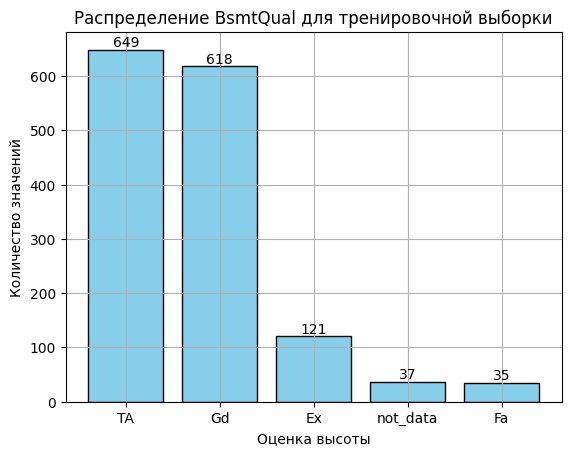

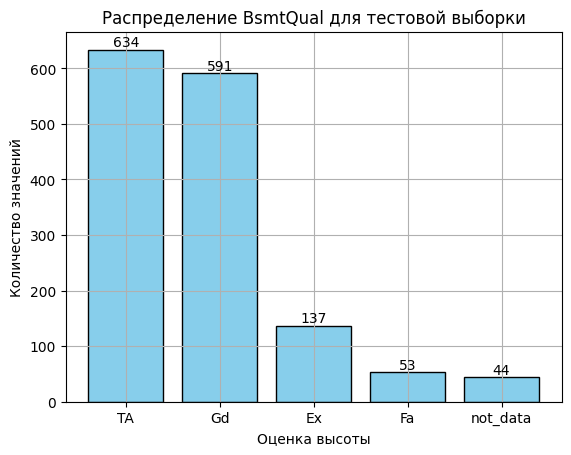

In [94]:
bsmt_qual_train = df_train['BsmtQual'].copy()
bsmt_qual_test = df_test['BsmtQual'].copy()
bsmt_qual_train.fillna('not_data', inplace=True)
bsmt_qual_test.fillna('not_data', inplace=True)

bar_container = plt.bar(bsmt_qual_train.value_counts().index, bsmt_qual_train.value_counts(), color='skyblue', edgecolor='black', )
plt.title('Распределение BsmtQual для тренировочной выборки')
plt.xlabel('Оценка высоты')
plt.ylabel('Количество значений')
plt.grid()
plt.bar_label(bar_container)
plt.show()

bar_container = plt.bar(bsmt_qual_test.value_counts().index, bsmt_qual_test.value_counts(), color='skyblue', edgecolor='black')
plt.title('Распределение BsmtQual для тестовой выборки')
plt.xlabel('Оценка высоты')
plt.ylabel('Количество значений')
plt.bar_label(bar_container)
plt.grid()
plt.show()

Построим гистограммы распределения для GarageYrBlt

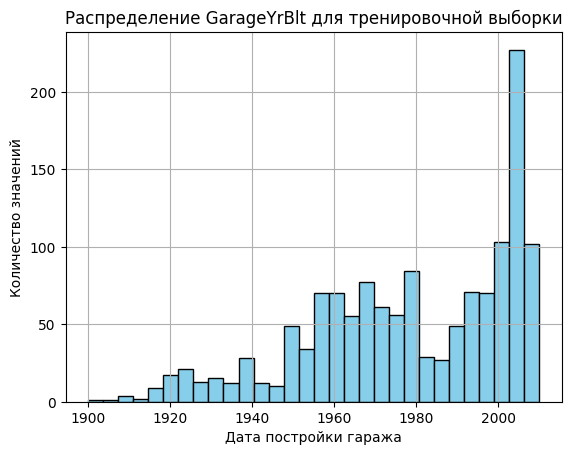

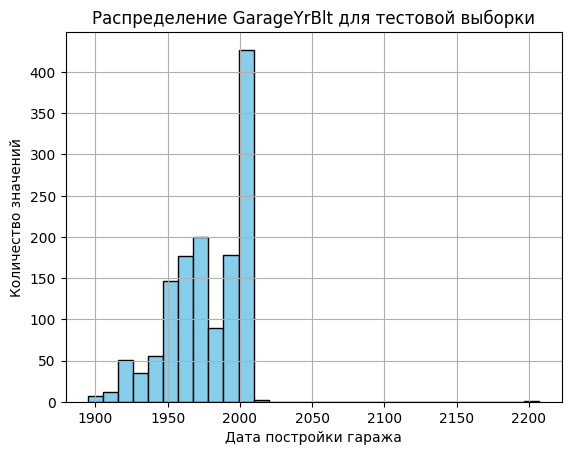

In [95]:
plt.hist(df_train['GarageYrBlt'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение GarageYrBlt для тренировочной выборки')
plt.xlabel('Дата постройки гаража')
plt.ylabel('Количество значений')
plt.grid()
plt.show()

plt.hist(df_test['GarageYrBlt'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение GarageYrBlt для тестовой выборки')
plt.xlabel('Дата постройки гаража')
plt.ylabel('Количество значений')
plt.grid()
plt.show()

Из распределения BsmtQual видно, что преобладают оценки "TA" и "Gd". Оценок "EX" меньше, количество оценок "Fa" совсем мало. Оценки "Po" и "Na", описанные в комментариях вообще не представлены.

Из распределение GarageYrBlt видно, что количество гаражей, построенных после 2000 годов преобладают, но и более старые присутствуют.

Также в тестовой выборке обнаружен выброс.

Посмотрим сколько аномальных значений по этому столбцу


In [96]:
print(df_test[df_test['GarageYrBlt'] > 2010])

     LandContour  GarageYrBlt  FullBath  1stFlrSF  BsmtFinSF1  TotRmsAbvGrd  \
1132         HLS       2207.0         2      1564       583.0             6   

     ExterQual  OpenPorchSF Heating Condition2  OverallQual  GarageCars  \
1132        Gd            0    GasA       Norm            8         2.0   

     KitchenQual  KitchenAbvGr  GrLivArea  2ndFlrSF CentralAir BsmtQual  \
1132          Ex             1       1564         0          Y       Gd   

      TotalBsmtSF  Fireplaces  
1132       1546.0           1  


Данное значение всего одно. Сделаем его None, а после решим чем заполнить пропуски.

In [97]:
df_test.loc[df_test['GarageYrBlt'] > 2010, 'GarageYrBlt'] = None

#### Корреляционная матрица

Построим корреляционную матрицу для тренировочной выборки, чтобы посмотреть зависимости между параметрами

Для начала сделаем копию датасета.

Создадим бинарные признаки для столбцов, в которых присутствуют пропущенные значения

In [98]:
df_train_corr = df_train.copy()
for column in df_train_corr.columns:
    if df_train_corr[column].isnull().any():
        df_train_corr[f'{column}_missing'] = df_train_corr[column].isnull().astype(int)

Поскольку наш датафрейм содержит не только числовые значения, то необходимо привести все значения к числовом формату. Для построения корреляционной матрицы отлично подходит label кодирование.


In [99]:
label_encoder = {}
for column in df_train_corr.select_dtypes(include=['object']).columns:
    label_encoder[column] = LabelEncoder()
    df_train_corr[column] = label_encoder[column].fit_transform(df_train_corr[column])

Рассчитаем корреляционную матрицу

In [100]:
full_correlation_matrix = df_train_corr.corr()

Для удобства отобразим данную матрицу ввиде тепловой карты

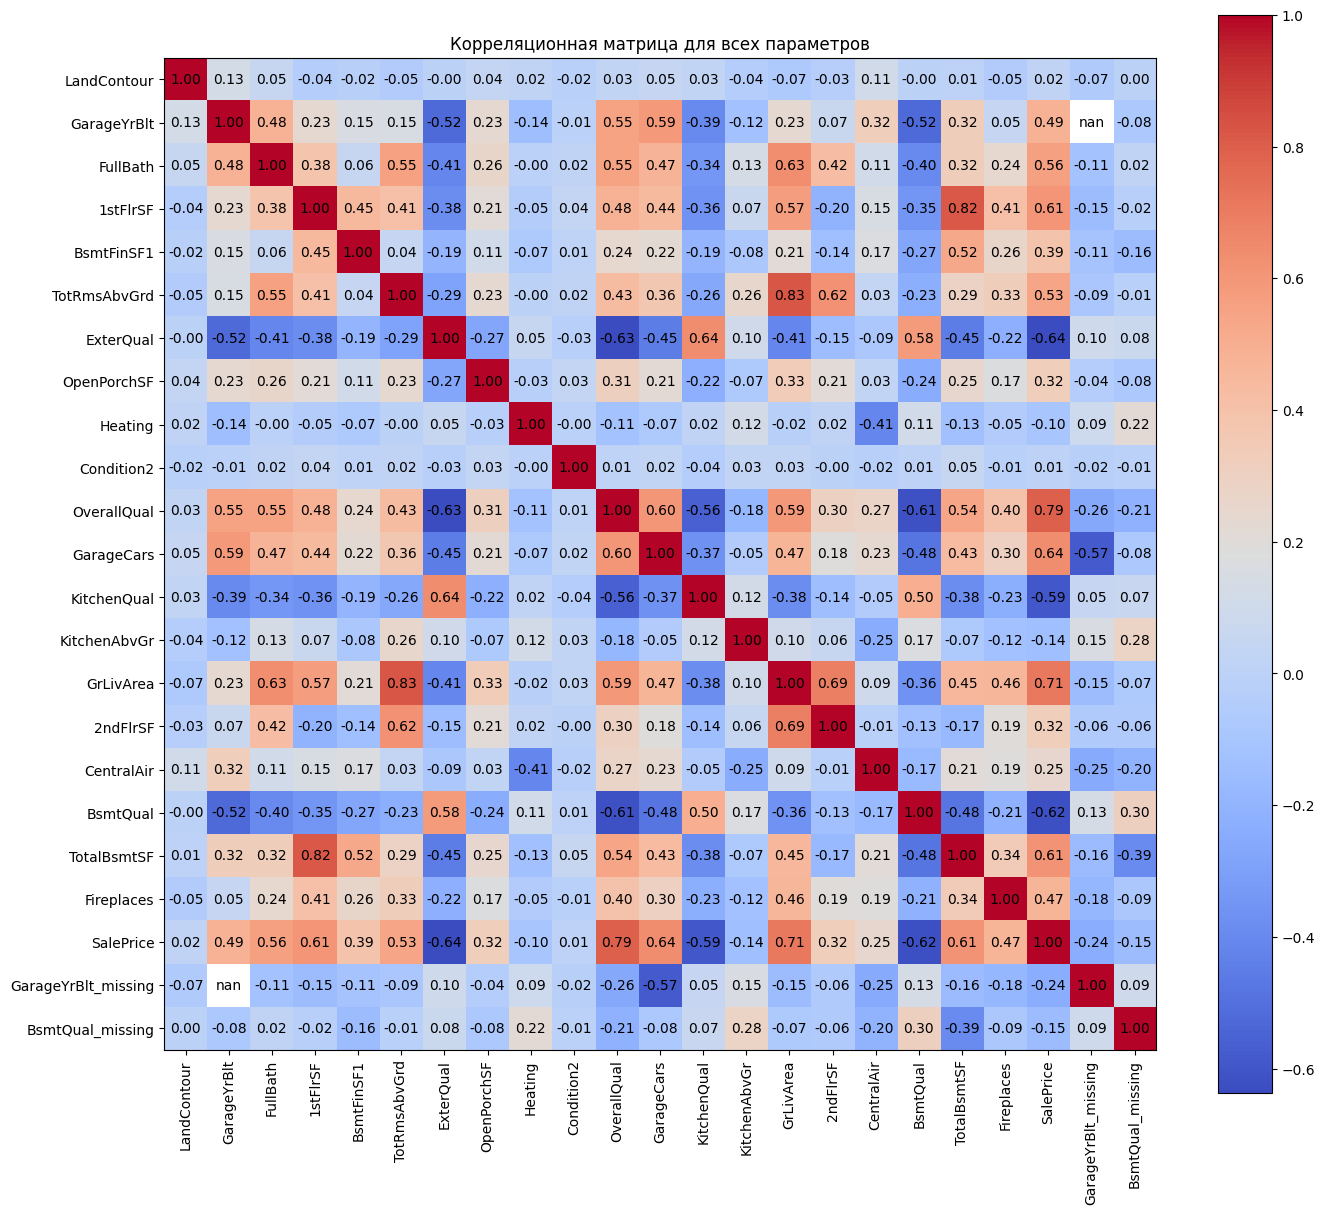

In [101]:
plt.figure(figsize=(16, 14))
plt.imshow(full_correlation_matrix, cmap="coolwarm", interpolation='none')
plt.colorbar()
plt.xticks(range(len(full_correlation_matrix.columns)), full_correlation_matrix.columns, rotation=90)
plt.yticks(range(len(full_correlation_matrix.columns)), full_correlation_matrix.columns)
for i in range(len(full_correlation_matrix.columns)):
    for j in range(len(full_correlation_matrix.columns)):
        text = plt.text(j, i, f"{full_correlation_matrix.iloc[i, j]:.2f}",
                        ha="center", va="center", color="black")
plt.title("Корреляционная матрица для всех параметров")
plt.show()

Данные местами сильно коррелируют между собой. Причем эти зависимости вполне логичны с точки зрения здравого смысла. Из этого можно сделать вывод что данные описывают реальную ситуацию.

Цена на жилье зависит от многих факторов. Наблюдается обратная корреляция с некоторыми из параметров. Причем данные параметры категориальные. Здесь проявляется недостаток label кодирования, который заключается в том, что такой подход добавляет зависимости, которых изначально нет.

Дело в том, что категории добавлялись случайным образом, а не по возрастанию значимости.

Condition2 и LandContour слабо коррелируют с остальными параметрами.

Возвращаясь к пропущенным значениям видим, что GarageYrBlt_missing сильно коррелирует с GarageCars, а BsmtQual_missing имеет корреляцию с TotalBsmtSF.

Сам признак BsmtQual сильно коррелирует с другими Qual признаками, а также зависит от TotalBsmtSF.

GarageYrBlt коррелирует с количеством мест в гараже, а также с Qual признаками.


#### Обработка значения для BsmtQual

Посмотрим на значения в TotalBsmtSF при пропущенных значениях в BsmtQual

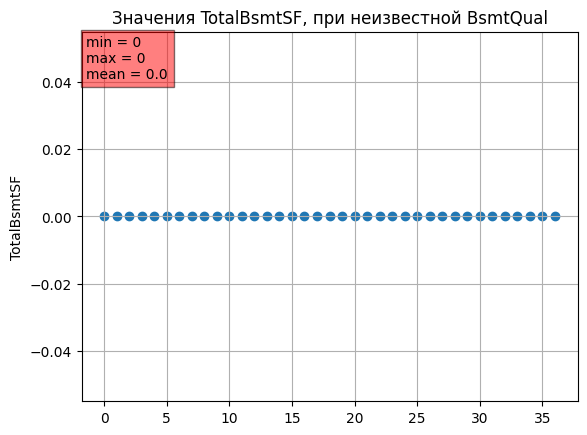

In [102]:
def show_none_column(df, none_column_name, check_column_name):
    df_none = df.loc[df[none_column_name].isnull(), [none_column_name, check_column_name]]
    df_none_min = df_none[check_column_name].min()
    df_none_max = df_none[check_column_name].max()
    df_none_mean = df_none[check_column_name].mean()
    f, ax = plt.subplots()
    plt.scatter(range(len(df_none)), df_none[check_column_name])
    plt.title(f'Значения {check_column_name}, при неизвестной {none_column_name}')
    plt.ylabel(check_column_name)
    plt.text(0.01, 0.99, f'min = {df_none_min}\nmax = {df_none_max}\nmean = {df_none_mean}',
             ha='left', va='top', transform=ax.transAxes, bbox={'facecolor': 'red', 'alpha': 0.5})
    plt.grid()
    plt.show()

show_none_column(df_train, 'BsmtQual', 'TotalBsmtSF')

Все значения 0, а значит подвала просто нет. Посмотрим есть ли значения отличные от none, при прощади подвала равной 0.

А также проделаем такую же операцию для тестовой выборки


Количество значений отличных от none при TotalBsmtSF = 0 : 0


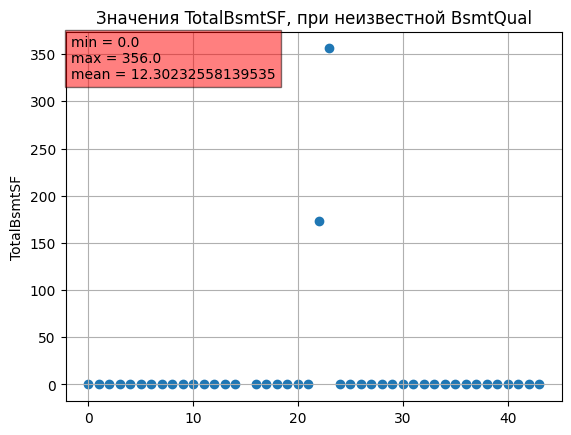


Количество значений отличных от none при TotalBsmtSF = 0 : -3


In [103]:
print(f'Количество значений отличных от none при TotalBsmtSF = 0 : ', end='')
print(len(df_train[df_train['TotalBsmtSF'] == 0]) - len(df_train[df_train['BsmtQual'].isnull()]))
show_none_column(df_test, 'BsmtQual', 'TotalBsmtSF')
print(f'\nКоличество значений отличных от none при TotalBsmtSF = 0 : ', end='')
print(len(df_test[df_test['TotalBsmtSF'] == 0]) - len(df_test[df_test['BsmtQual'].isnull()]))

Отлично. Мы выяснили, что если площадь подвала равна 0, то BsmtQual должна быть NA.

Правда в тестовой выборке есть и другие 3 пропущенные значения. Их необходимо обработать отдельно.

Заполним пропуски

In [104]:
df_train.loc[df_train['TotalBsmtSF'] == 0, 'BsmtQual'] = 'NA'
df_test.loc[df_test['TotalBsmtSF'] == 0, 'BsmtQual'] = 'NA'

#### Обработка значения для GarageYrBlt

Попробуем применить такую же логику для GarageYrBlt.
Посмотрим на значения в GarageCars при пропущенных значениях в GarageYrBlt

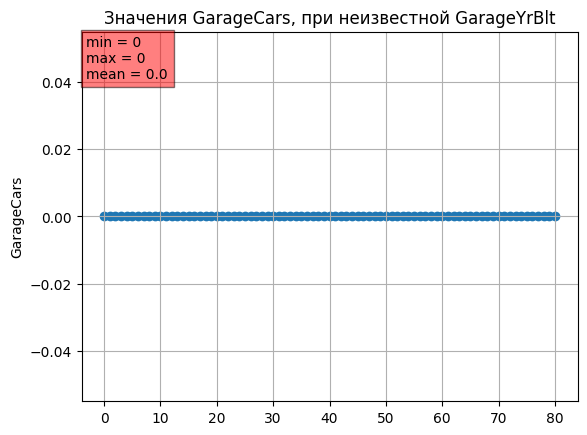

Количество значений отличных от none при GarageCars = 0 : 0


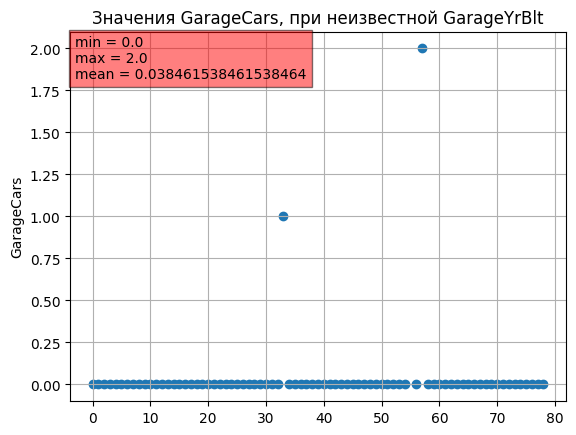

Количество значений отличных от none при GarageCars = 0 : -3


In [105]:
show_none_column(df_train, 'GarageYrBlt', 'GarageCars')
print(f'Количество значений отличных от none при GarageCars = 0 : ', end='')
print(len(df_train[df_train['GarageCars'] == 0]) - len(df_train[df_train['GarageYrBlt'].isnull()]))
show_none_column(df_test, 'GarageYrBlt', 'GarageCars')
print(f'Количество значений отличных от none при GarageCars = 0 : ', end='')
print(len(df_test[df_test['GarageCars'] == 0]) - len(df_test[df_test['GarageYrBlt'].isnull()]))

Наблюдаем аналогичную картину, но данный признак числовой, что немного усложняет нашу задачу.

Заполним год постройки гаража 0 и создадим дополнительный бинарный признак, который будет описывать наличие гаража. Подобный подход позволит явно указать наличие и отсутствие гаража, а также дополнительно выделит эти случаи среди других годов

In [106]:
df_train.loc[df_train['GarageCars'] == 0, 'GarageYrBlt'] = 0
df_train['HaveGarage'] = 0
df_train.loc[df_train['GarageCars'] == 0, 'HaveGarage'] = 1

df_test.loc[df_test['GarageCars'] == 0, 'GarageYrBlt'] = 0
df_test['HaveGarage'] = 0
df_test.loc[df_test['GarageCars'] == 0, 'HaveGarage'] = 1

#### Обработка оставшихся значений

Посмотрим остались ли пропущенные значения и сколько их

In [107]:
print(f'Количество пропущенных значений в тренировочном датасете: {df_train.isnull().sum().sum()}')
print(f'Количество пропущенных значений в тестовом датасете: {df_test.isnull().sum().sum()}')

Количество пропущенных значений в тренировочном датасете: 0
Количество пропущенных значений в тестовом датасете: 10


В тренировочном датасете не осталось пропусков, в тестовом их всего 10.

Посмотрим какие значение пропущены

In [108]:
print(df_test[df_test.isna().any(axis=1)])

     LandContour  GarageYrBlt  FullBath  1stFlrSF  BsmtFinSF1  TotRmsAbvGrd  \
95           Lvl       1917.0         1       725         0.0             6   
660          Lvl       1946.0         1       896         NaN             4   
666          Lvl          NaN         2      1242       196.0             8   
757          Lvl       1895.0         1       825         0.0             6   
758          Lvl       1910.0         1       671         0.0             5   
1116         Lvl          NaN         2       942       548.0             6   
1132         HLS          NaN         2      1564       583.0             6   

     ExterQual  OpenPorchSF Heating Condition2  ...  GarageCars  KitchenQual  \
95          TA            0    GasA       Norm  ...         1.0          NaN   
660         TA            0    GasA       Norm  ...         1.0           TA   
666         TA            0    GasA       Norm  ...         1.0           TA   
757         TA          123    GasA       Norm 

Заполним GarageYrBlt медианой, а BsmtQual наиболее часто встречающимся значением

In [109]:
df_test.loc[df_test['GarageYrBlt'].isnull(), 'GarageYrBlt'] = df_test.loc[df_test['GarageYrBlt'] != 0, 'GarageYrBlt'].mean()
df_test.loc[df_test['BsmtQual'].isnull(), 'BsmtQual'] = 'TA'

Посмотрим на оставшиеся неизвестные значения

In [110]:
print(df_test[df_test.isna().any(axis=1)])

     LandContour  GarageYrBlt  FullBath  1stFlrSF  BsmtFinSF1  TotRmsAbvGrd  \
95           Lvl  1917.000000         1       725         0.0             6   
660          Lvl  1946.000000         1       896         NaN             4   
1116         Lvl  1977.555072         2       942       548.0             6   

     ExterQual  OpenPorchSF Heating Condition2  ...  GarageCars  KitchenQual  \
95          TA            0    GasA       Norm  ...         1.0          NaN   
660         TA            0    GasA       Norm  ...         1.0           TA   
1116        TA            0    GasA       Norm  ...         NaN           Gd   

     KitchenAbvGr  GrLivArea  2ndFlrSF  CentralAir BsmtQual TotalBsmtSF  \
95              1       1224       499           N       Gd       689.0   
660             1        896         0           Y       TA         NaN   
1116            1       1828       886           Y       Gd       859.0   

      Fireplaces  HaveGarage  
95             0           0  

Числовые признаки заполним медианой, а категориальные заполним самым часто встречающимся значением

In [111]:
total_bsmt_mean = df_test['TotalBsmtSF'].mean()
if total_bsmt_mean == 0:
    df_test.loc[df_test['TotalBsmtSF'].isnull(), 'BsmtQual'] = 'NA'
df_test.loc[df_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = total_bsmt_mean
df_test.loc[df_test['BsmtFinSF1'].isnull(), 'BsmtFinSF1'] = df_test['BsmtFinSF1'].mean()
df_test.loc[df_test['KitchenQual'].isnull(), 'KitchenQual'] = df_test['KitchenQual'].value_counts().index[0]
garage_cars_most_popular = df_test['GarageCars'].value_counts().index[0]
if garage_cars_most_popular == 0:
    df_test.loc[df_test['GarageCars'].isnull(), 'GarageYrBlt'] = garage_cars_most_popular
df_test.loc[df_test['GarageCars'].isnull(), 'GarageCars'] = garage_cars_most_popular
print(f'Количество пропущенных значений в тестовом датасете: {df_test.isnull().sum().sum()}')

Количество пропущенных значений в тестовом датасете: 0


### Обработка нечисловых значений

Для работы с данными гораздо удобнее представить их в числовом формате, потому что большинство моделей машинного обучения работают только с числами, а также все расчеты тоже удобнее производить с числами.

Поскольку количество категорий у нас не очень большое, то лучше всего будет применить метод кодирования One-Hot Encoder. Это преобразует наши данные к числовому формату без добавления несуществующих зависимостей.


In [112]:
categorical_features_list = df_train.columns[df_train.dtypes == 'object']
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(df_train[categorical_features_list])
encoded_train = pd.DataFrame(one_hot_encoder.transform(df_train[categorical_features_list]), columns=one_hot_encoder.get_feature_names_out(categorical_features_list))
encoded_test = pd.DataFrame(one_hot_encoder.transform(df_test[categorical_features_list]), columns=one_hot_encoder.get_feature_names_out(categorical_features_list))
df_train_encoded = pd.concat([df_train, encoded_train], axis=1)
df_train_encoded.drop(categorical_features_list, axis=1, inplace=True)
df_test_encoded = pd.concat([df_test, encoded_test], axis=1)
df_test_encoded.drop(categorical_features_list, axis=1, inplace=True)

Мы создали новые датафреймы для теста и трейна с закодированными значениями. Если при построении модели возникнут проблемы с кодировкой, то можно будет использовать неизмененные датасеты

### Обработка числовых значений

Некоторые модели машинного обучения чувствительны к масштабу данных, а значит наши данные лучше нормализовать. Будем использовать minmax нормализацию. Подобный подход сведет все наши данные к диапазону от 0 до 1.

Также выделим нашу целевую переменную в отдельную серию, ее нам нормализовать не нужно

In [113]:
y = df_train_encoded['SalePrice']
df_train_encoded.drop('SalePrice', axis=1, inplace=True)

Сделаем minmax нормализацию. При этом учтем тот факт, что GarageYrBlt нужно обработать отдельно.

In [114]:
def min_max_norm(df, num_feature):
    garage_not_zero = df.loc[df_train_encoded['GarageYrBlt'] != 0, 'GarageYrBlt']
    garage_not_zero = (garage_not_zero - garage_not_zero.min()) / (garage_not_zero.max() - garage_not_zero.min())
    df.loc[df_train_encoded['GarageYrBlt'] != 0, 'GarageYrBlt'] = garage_not_zero
    num_feature = num_feature.drop('GarageYrBlt')
    df[num_feature] = ((df[num_feature] - df[num_feature].min()) /
                       (df[num_feature].max() - df[num_feature].min()))
    return df


numeric_feature_list = df_train.columns[df_train.dtypes != 'object']
numeric_feature_list = numeric_feature_list.drop('SalePrice')
df_train_encoded = min_max_norm(df_train_encoded, numeric_feature_list)
df_test_encoded = min_max_norm(df_test_encoded, numeric_feature_list)

## Создание модели

Мы анализ и предобработку данных, теперь необходимо создать модель.

Для нашей задачи подойдут
1. Линейная регрессия
2. Случайный лес
3. Градиентный бустинг

В качестве метрик качества будем использовать RMSE и MAPE

Построим данные модели и сравним результаты, после сделаем выводы о дальнейших действиях.


### Линейная регрессия
Разделим наши данные на тренировочную и тестовую выборку

In [115]:
x_train, x_test, y_train, y_test = train_test_split(df_train_encoded, y, test_size=0.2, random_state=7)

Посмотрим на значения в SavePrice, чтобы понимать насколько хороший у нас получится показатель RMSE

In [116]:
print(f'Минимальное значение цены на жилье: {y.min()}')
print(f'Максимальное значение цены на жилье: {y.max()}')
print(f'Средние значение цены на жилье: {y.mean()}')
print(f'Медиана значений цены на жилье: {y.median()}')

Минимальное значение цены на жилье: 34900
Максимальное значение цены на жилье: 755000
Средние значение цены на жилье: 180921.19589041095
Медиана значений цены на жилье: 163000.0


Создадим модель линейной регрессии

In [117]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

Напишем функцию, которая будет рассчитывать наши метрики, а также визуализировать полученные результаты

In [118]:
def show_result(model, is_linear=False, is_rf=False, model_name='model', show_test=True, show_train=False):
    # Реализуем цикл для анализа тестовой и тренировочной выборки
    show_data = []
    if show_test:
        show_data.append('test')
    if show_train:
        show_data.append('train')
    for show in show_data:
        if show == 'test':
            y_pred = model.predict(x_test)
            y_real = y_test
        else:
            y_pred = model.predict(x_train)
            y_real = y_train
        # Рассчитаем метрики и выведем результат
        mse = mean_squared_error(y_real, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
        print(f'\nИмя модели: {model_name}')
        print(f'Выборка : {show}')
        print(f'RMSE: {round(rmse, 0)}')
        print(f'MAPE: {round(mape, 2)} %\n')
        print('Графики сравнения актуальных и предсказанных значений')
        # Построим графики значений предсказаний
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_real, y_pred, alpha=0.5, c='blue', label='Точки')
        plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--',
                 label='Идеальная кривая')
        plt.xlabel('Фактическая цена')
        plt.ylabel('Предсказанная цена')
        plt.title(f'Зависимость предсказанной цены от фактической ({show})')
        plt.legend()
        residuals = y_real - y_pred
        plt.subplot(1, 2, 2)
        plt.scatter(y_pred, residuals, alpha=0.5, c='blue', label='Точки')
        plt.axhline(0, color='red', linestyle='--', label='Идеальная кривая' )
        plt.xlabel('Предсказанная цена')
        plt.ylabel('Разница в ценах')
        plt.title(f'Зависимость разницы в ценах от предсказанной цены ({show})')
        plt.tight_layout()
        plt.show()
        # Построим график распределения разницы
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel('Разница')
        plt.ylabel('Частота')
        plt.title(f'Распределение разницы между предсказанным и фактическим значением цены ({show})')
        plt.show()
        # Посмотрим на коэффициенты линейной модели
        if is_linear or is_rf:
            # Создадим датафрейм коэффициентов
            if is_linear:
                coefficients = pd.DataFrame({
                    'Feature': x_train.columns,
                    'Coefficient': model.coef_
                })
            else:
                coefficients = pd.DataFrame({
                    'Feature': x_train.columns,
                    'Coefficient': model.feature_importances_
                })
            # Отсортируем значение
            coefficients['abs_Coefficient'] = coefficients['Coefficient'].abs()
            coefficients = coefficients.sort_values(by='abs_Coefficient', ascending=False)
            # Визуализируем результат
            plt.figure(figsize=(12, 8))
            plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
            plt.xlabel('Значение коэффициента')
            plt.ylabel('Признак')
            plt.title(f'Коэффициенты ({show})')
            plt.gca().invert_yaxis()
            plt.show()


Посмотрим на результаты нашей модели


Имя модели: Линейная регрессия
Выборка : test
RMSE: 38192.0
MAPE: 12.75 %

Графики сравнения актуальных и предсказанных значений


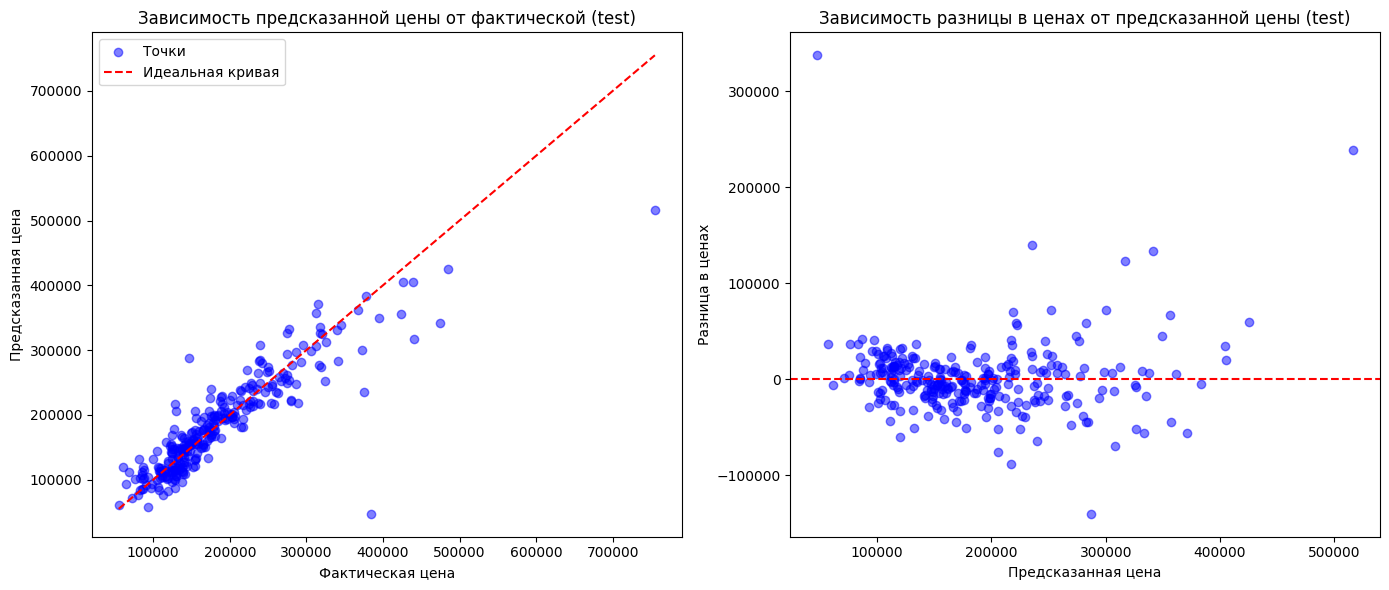

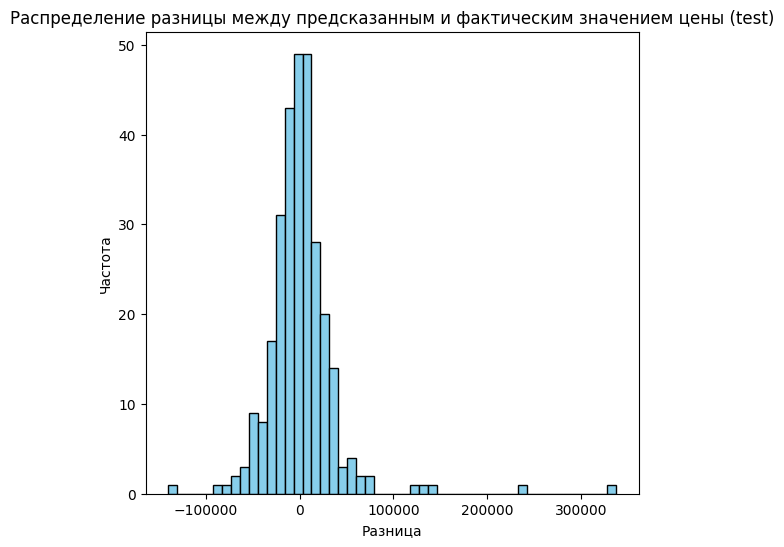

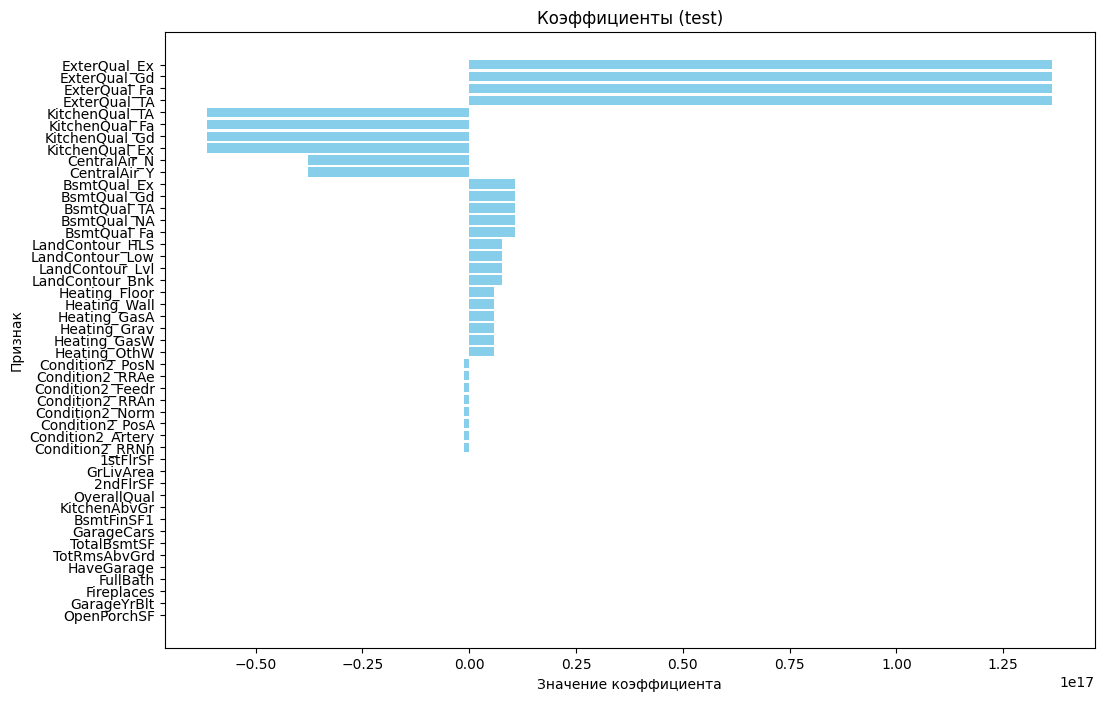


Имя модели: Линейная регрессия
Выборка : train
RMSE: 31651.0
MAPE: 12.0 %

Графики сравнения актуальных и предсказанных значений


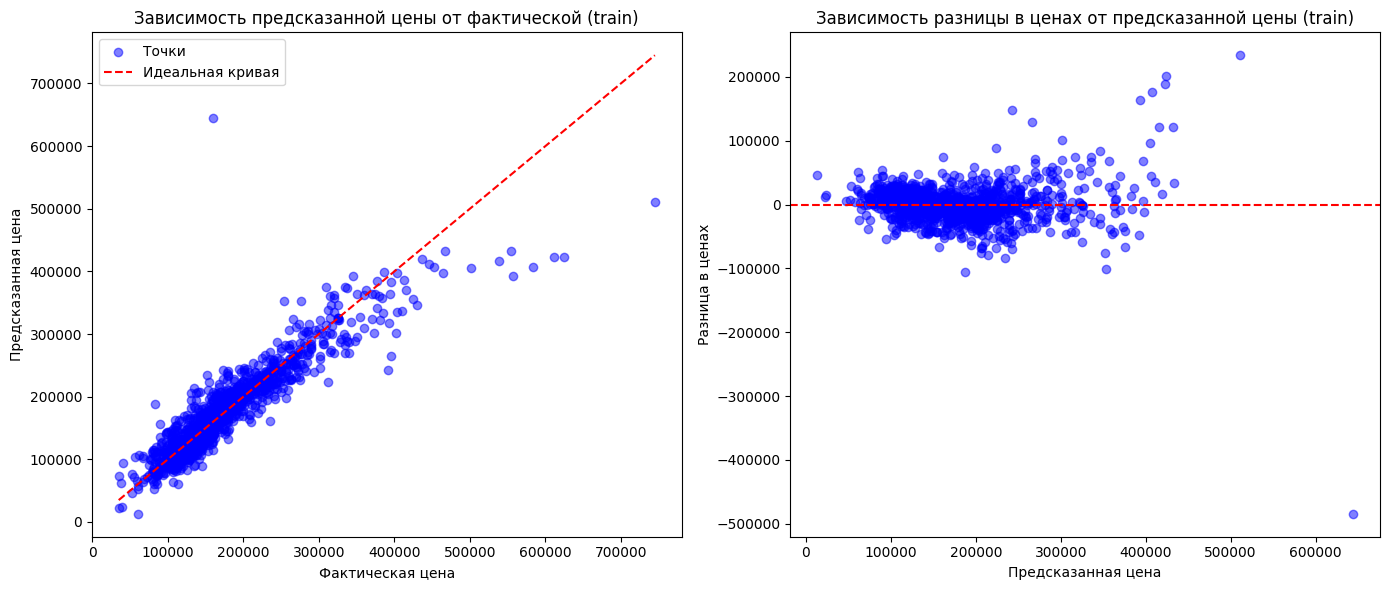

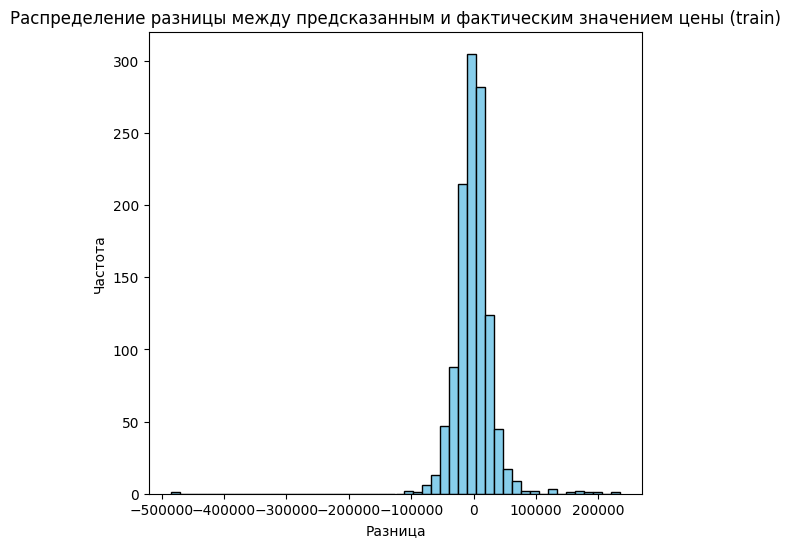

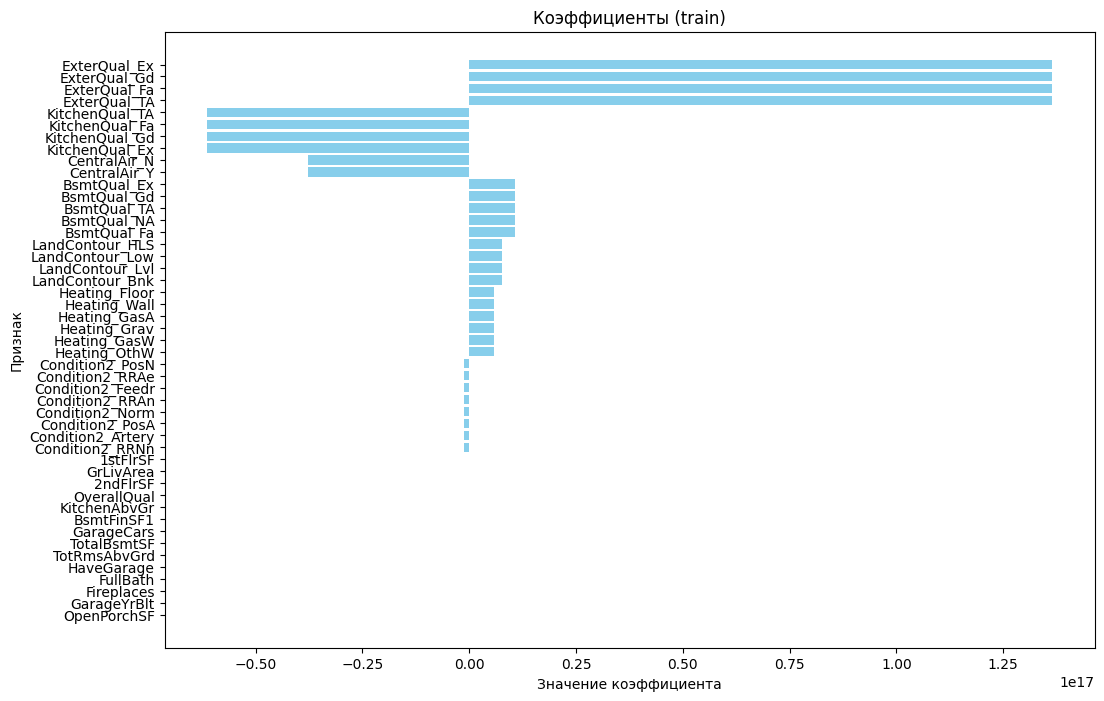

In [119]:
show_result(model, is_linear=True, model_name='Линейная регрессия', show_train=True, show_test=True)

Результаты далеко не самые плохие.

Для теста и трейна результаты идентичные.

RMSE практически равен минимальному значению в выборке, но учитывая практически 20 кратное превышение максимального значения над минимальным, это вполне неплохой результат.

MAPE равен 12%. С точки зрения стоимости жилья это вполне хороший показатель.

Практически все точки лежат вдоль идеальной кривой.

Из минусов можно выделить то, что модель очень плохо справляется с очень дешевыми и очень дорогими домами.

К тому же модель отдает сильное предпочтение только некоторым категориальным признакам, остальные коэффициенты равны или близки к 0. С точки зрения здравого смысла это выглядит не совсем правильно.

Попробуем применить регуляризацию и выровнять значения коэффициентов.

Попробуем L2 регуляризацию


Имя модели: Линейная регрессия с L2 регуляризацией
Выборка : test
RMSE: 34605.0
MAPE: 12.82 %

Графики сравнения актуальных и предсказанных значений


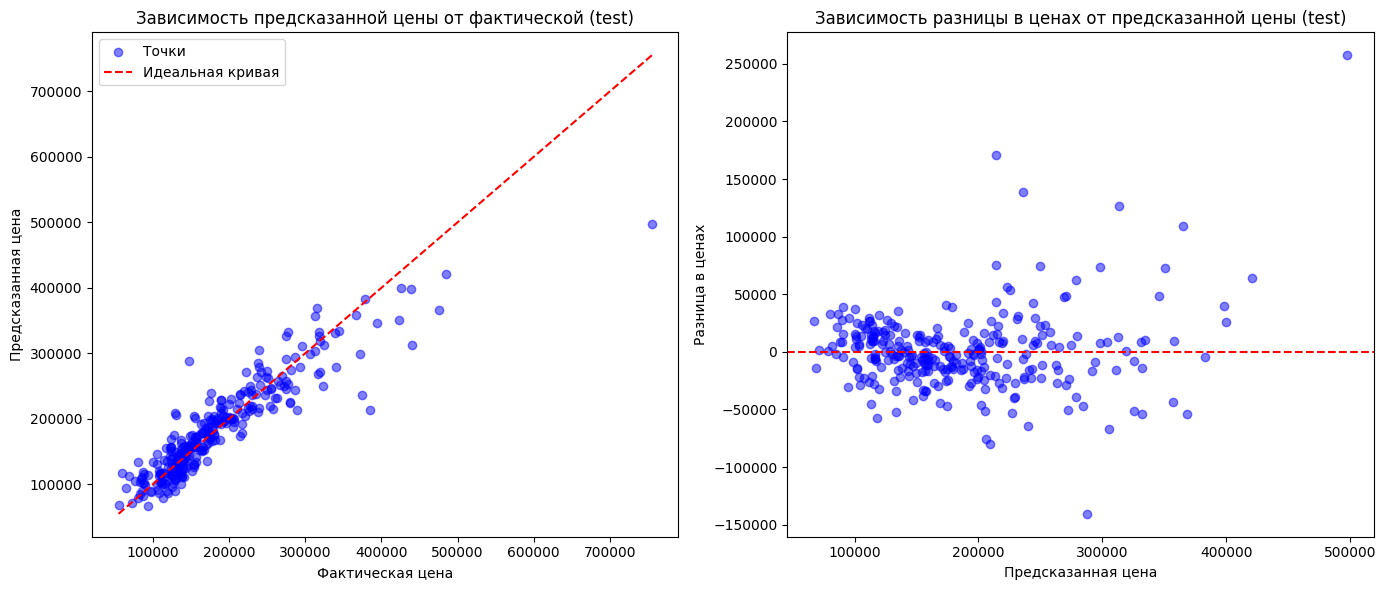

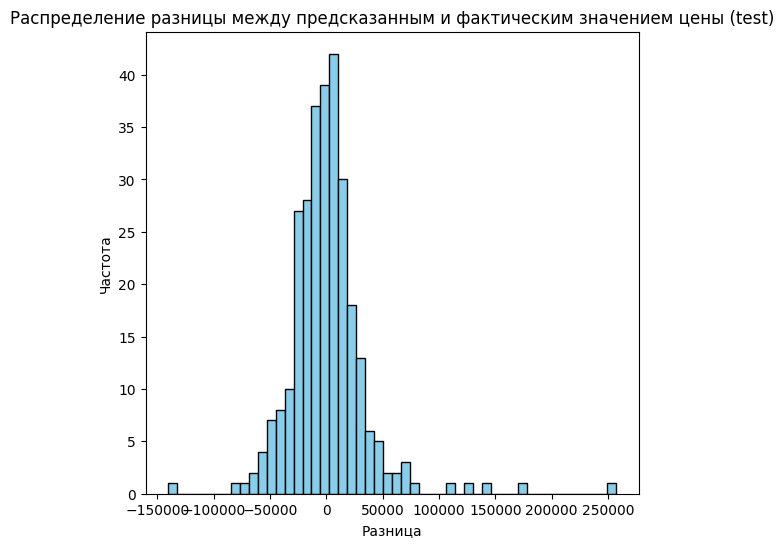

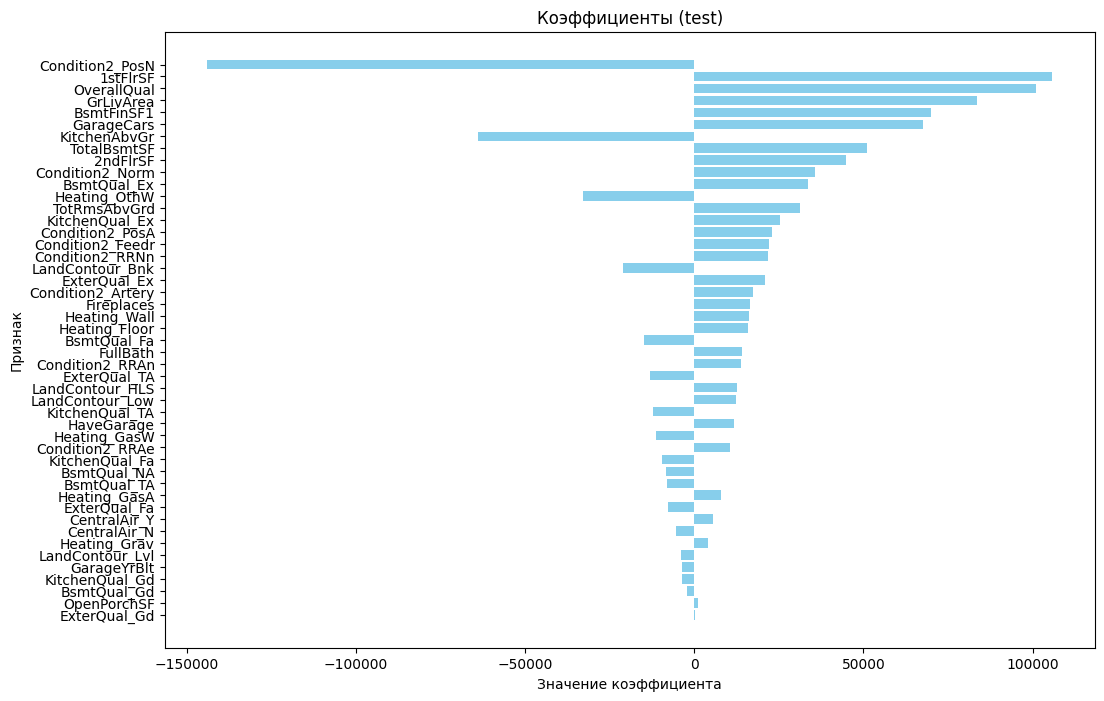


Имя модели: Линейная регрессия с L2 регуляризацией
Выборка : train
RMSE: 32214.0
MAPE: 12.2 %

Графики сравнения актуальных и предсказанных значений


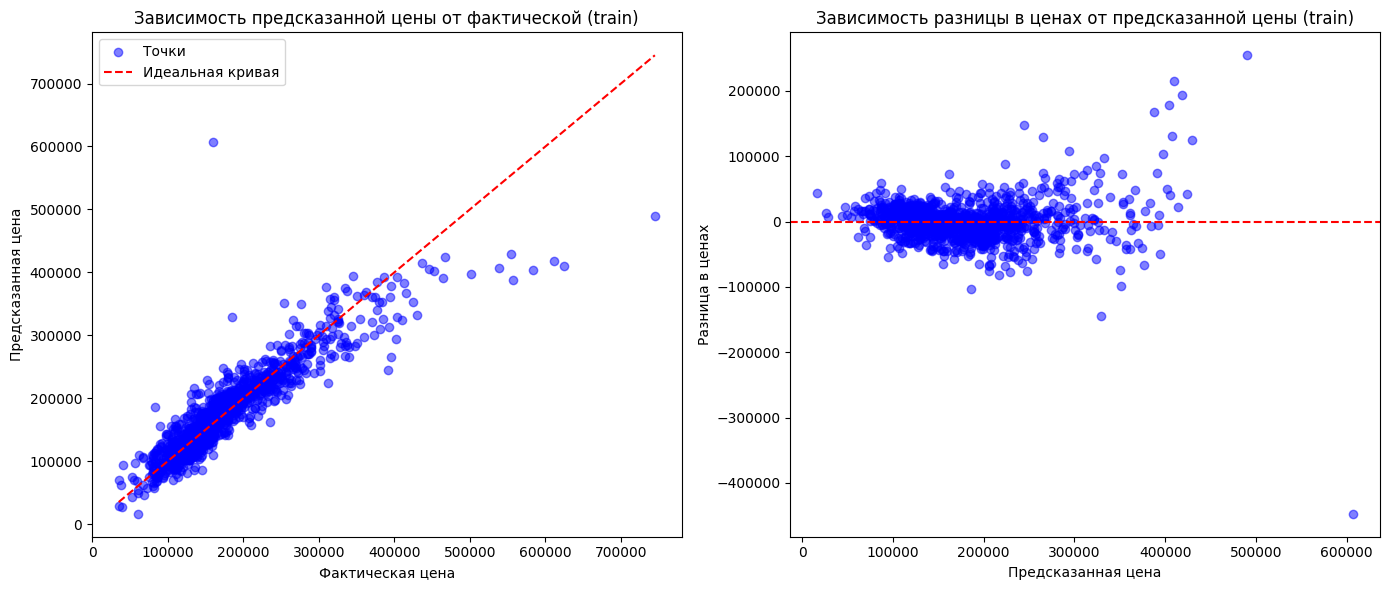

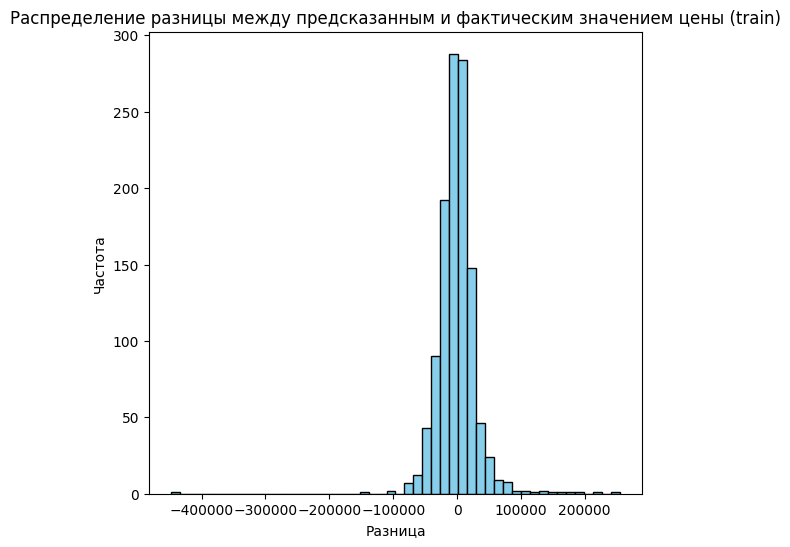

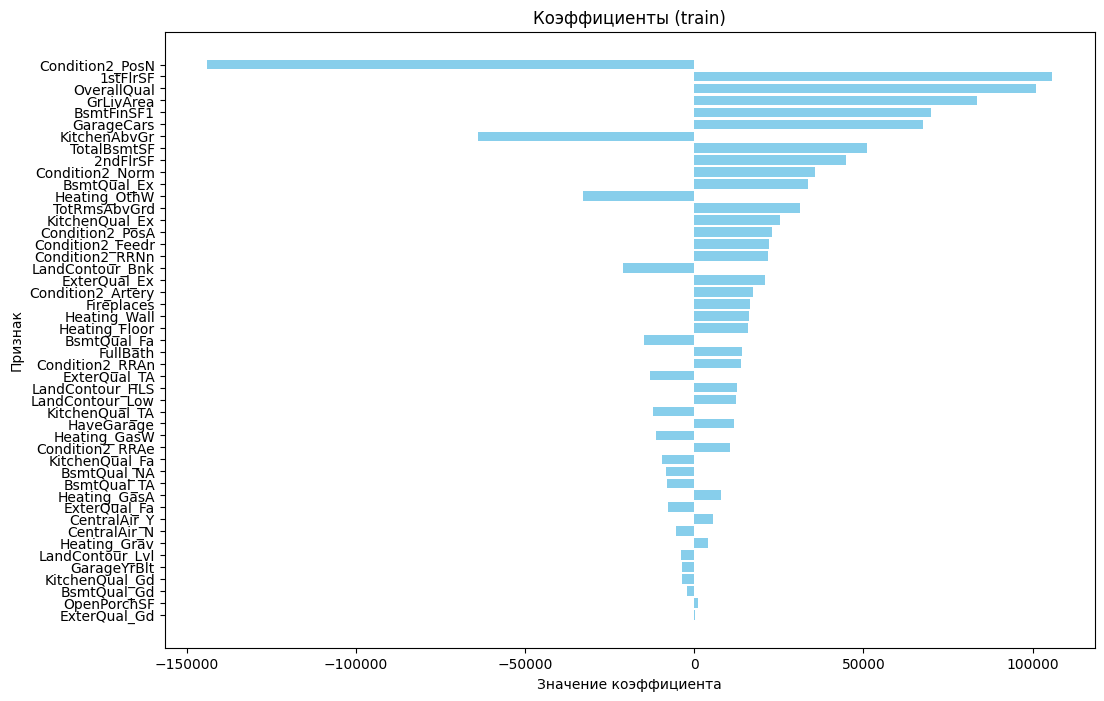

In [120]:
model_ridge = Ridge(alpha=1)
model_ridge.fit(x_train, y_train)
show_result(model_ridge, is_linear=True, model_name='Линейная регрессия с L2 регуляризацией', show_train=True,
            show_test=True)

Попробуем L1 регуляризацию


Имя модели: Линейная регрессия с L1 регуляризацией
Выборка : test
RMSE: 38084.0
MAPE: 12.72 %

Графики сравнения актуальных и предсказанных значений


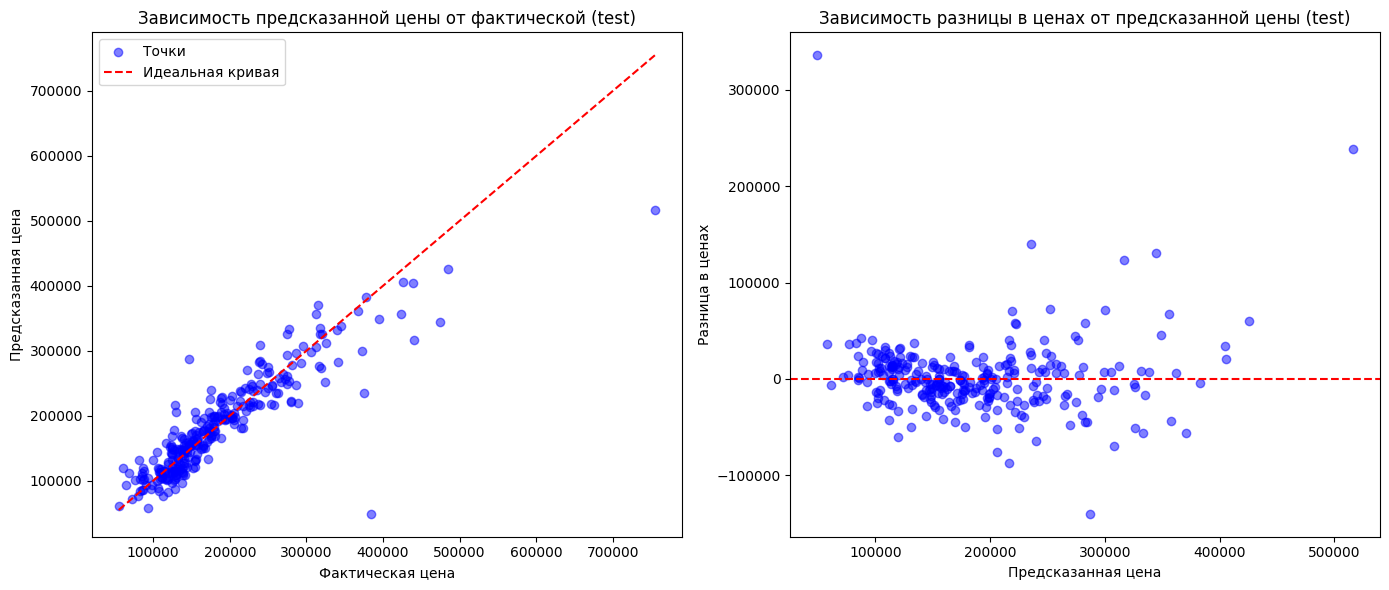

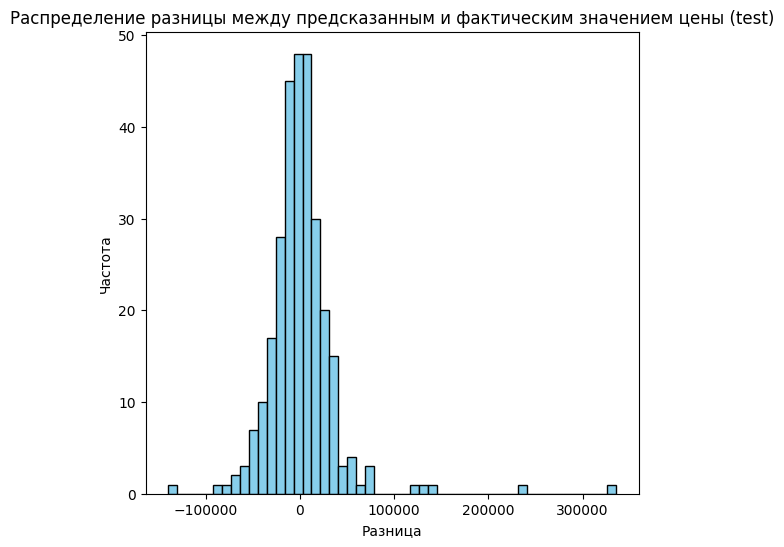

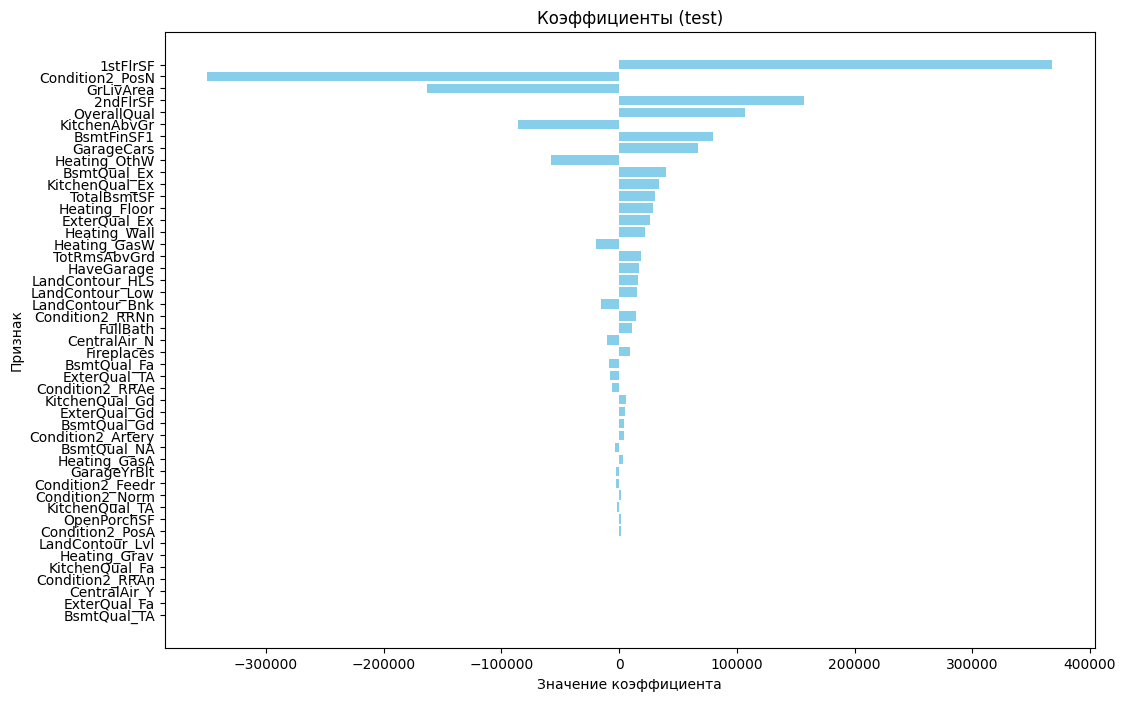


Имя модели: Линейная регрессия с L1 регуляризацией
Выборка : train
RMSE: 31653.0
MAPE: 11.99 %

Графики сравнения актуальных и предсказанных значений


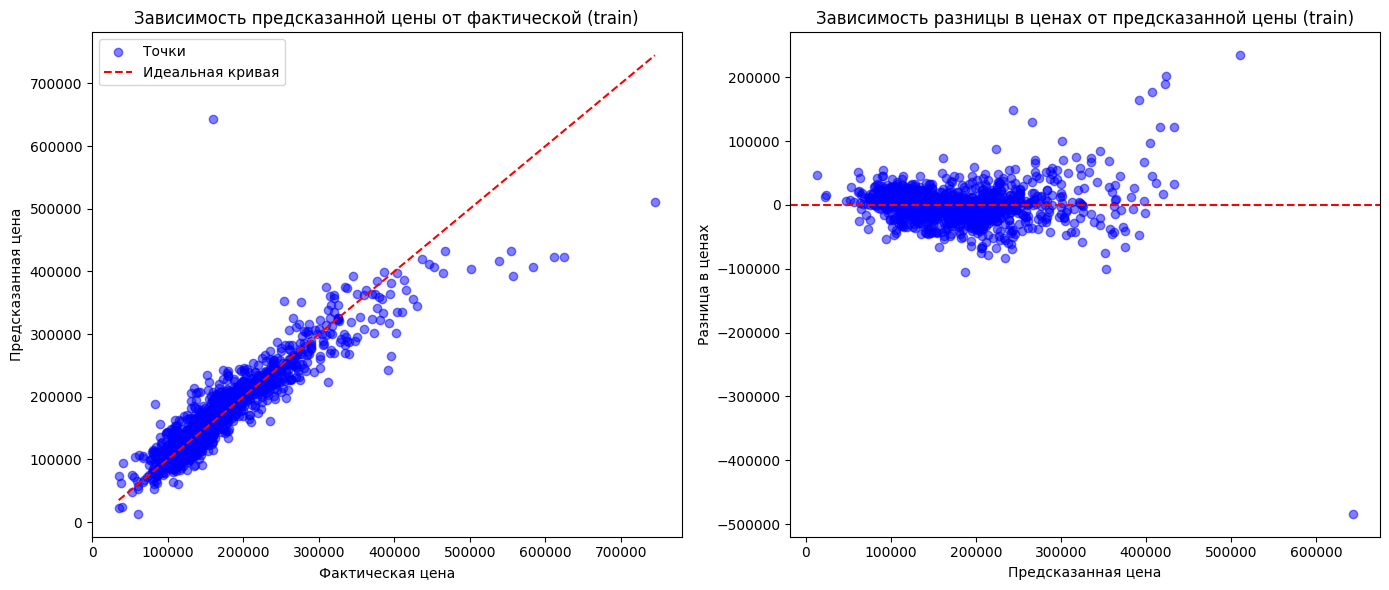

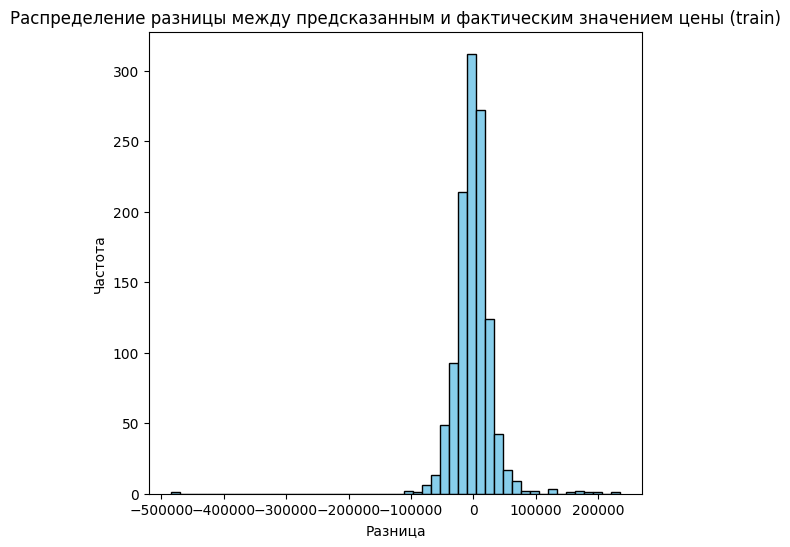

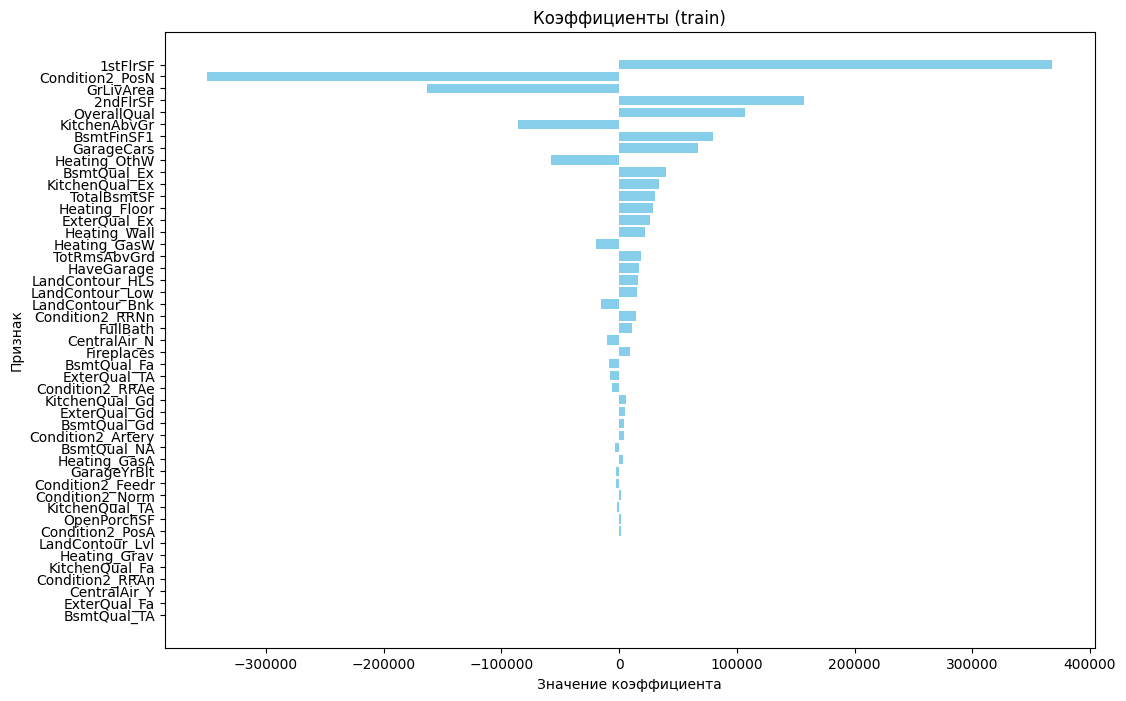

In [121]:
model_lasso = Lasso(alpha=1)
model_lasso.fit(x_train, y_train)
show_result(model_lasso, is_linear=True, model_name='Линейная регрессия с L1 регуляризацией', show_train=True,
            show_test=True)

Коэффициенты линейной регрессии изменились и стали больше похожи на реальные, но это слабо повлияло на точность модели. Метрики качества остались на прежнем уровне.

В итоге линейная модель имеет право на жизнь. Она достаточно хорошо описывает стоимость жилья в среднем ценовом сегменте.

### Случайный лес

Посмтроим модель случайного леса


Имя модели: Случайный лес
Выборка : test
RMSE: 27332.0
MAPE: 10.72 %

Графики сравнения актуальных и предсказанных значений


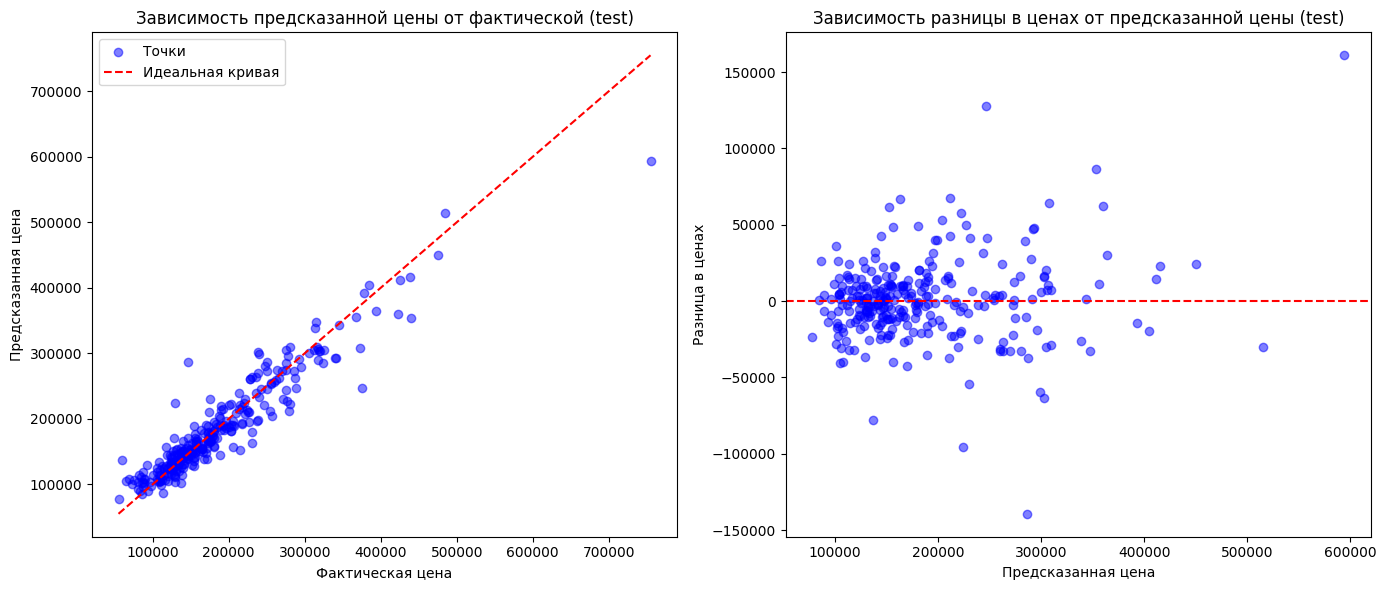

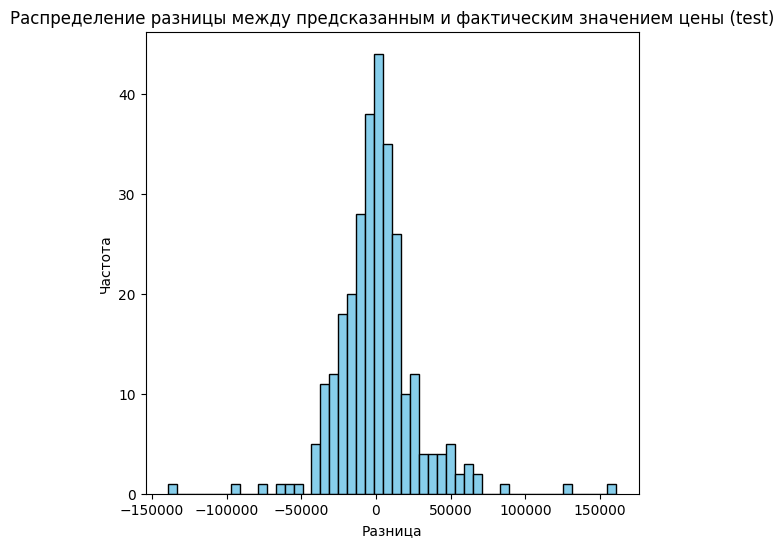

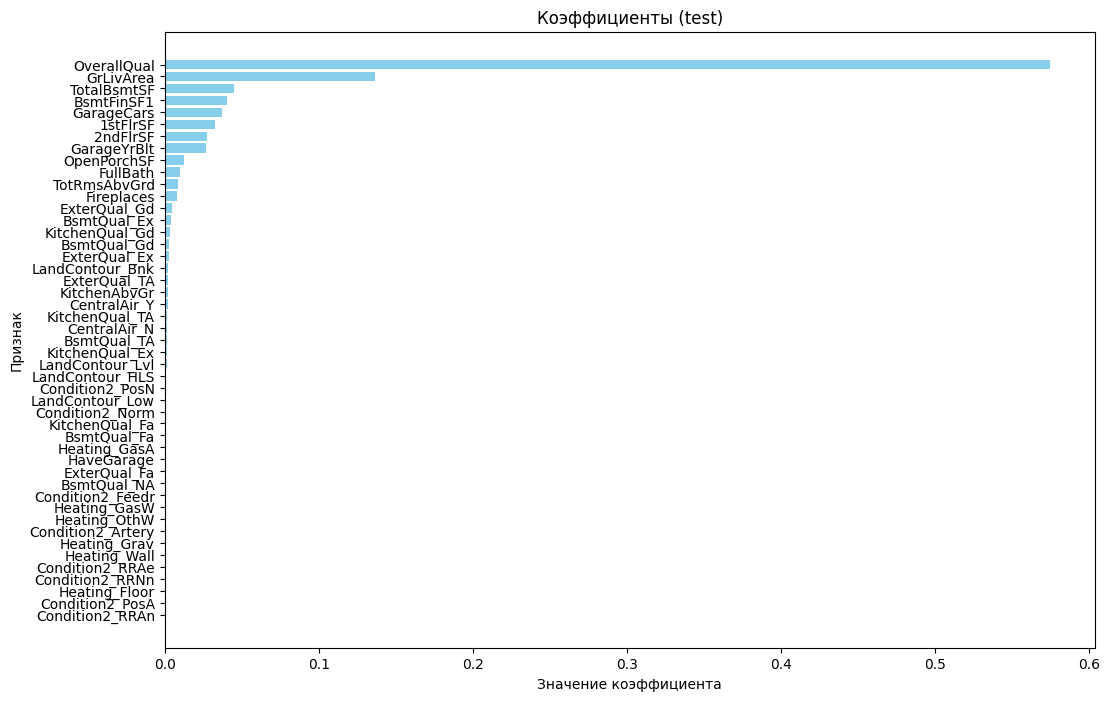


Имя модели: Случайный лес
Выборка : train
RMSE: 11846.0
MAPE: 4.12 %

Графики сравнения актуальных и предсказанных значений


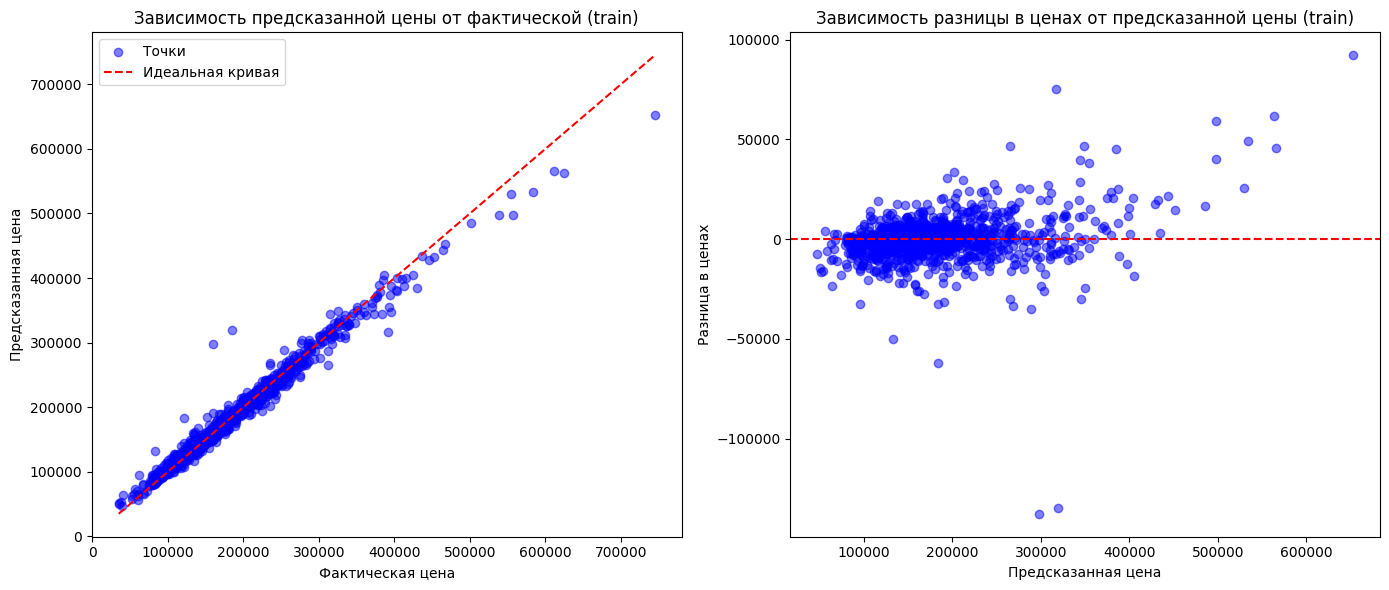

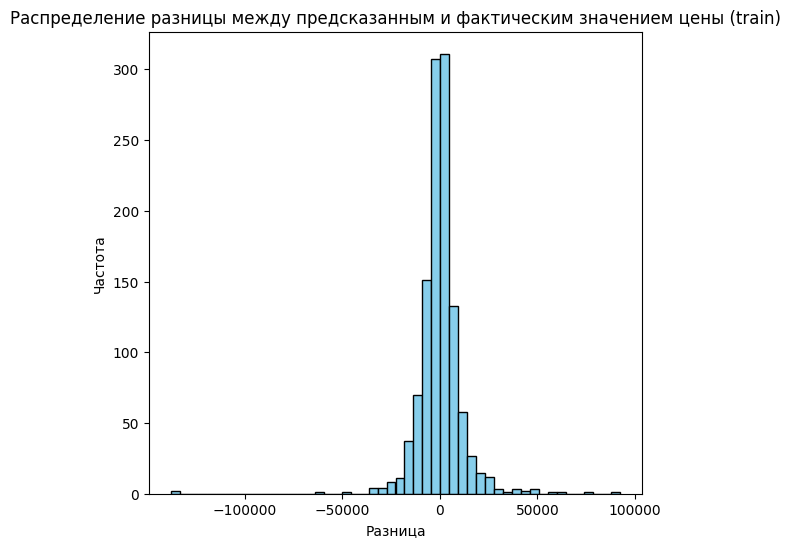

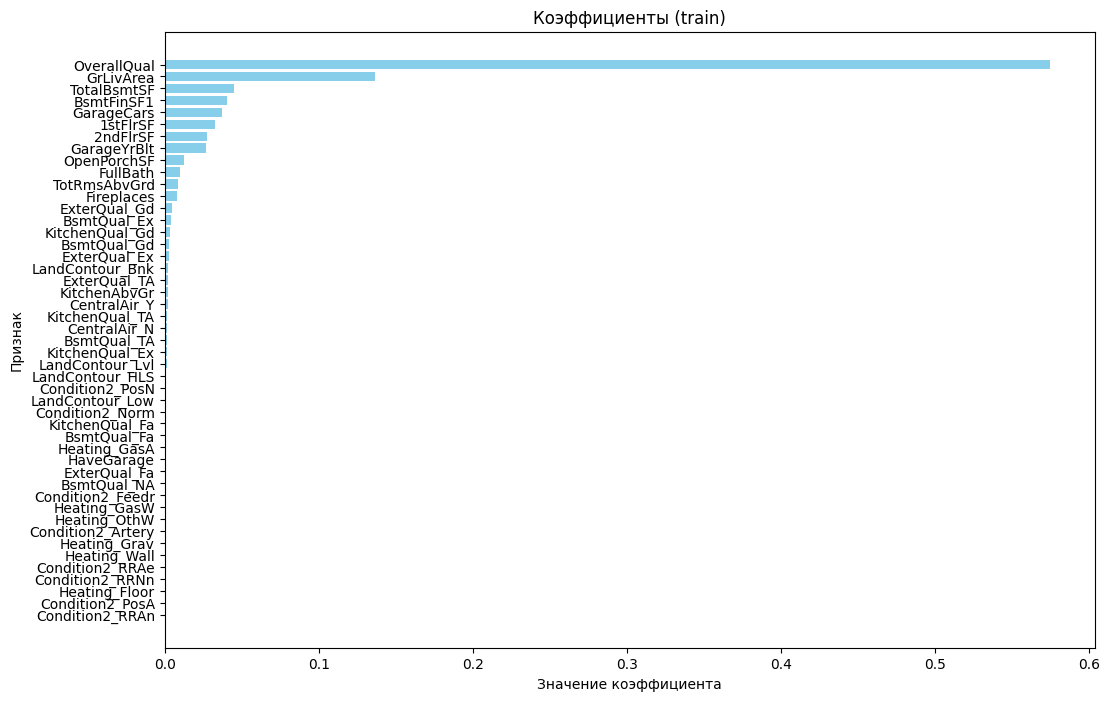

In [122]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=7)
model_rf.fit(x_train, y_train)
show_result(model_rf, is_linear=False, is_rf=True, model_name='Случайный лес', show_train=True,
            show_test=True)

Данная модель лучше описывает данные.

В области больших и маленьких цен точки приблизились к идеальной кривой. RMSE снизилось. Коэффициенты хоть и отдают сильное предпочтение определенным признакам, но признаки эти выглядят достаточно значимыми. Mape снизилась.

Правда точность на трейне сильно выше точности на тесте, а значит наблюдается переобучение.

Попробуем настроить параметры, чтобы снизить точность на трейне и повысить точность на тесте


Имя модели: Случайный лес
Выборка : test
RMSE: 27755.0
MAPE: 11.06 %

Графики сравнения актуальных и предсказанных значений


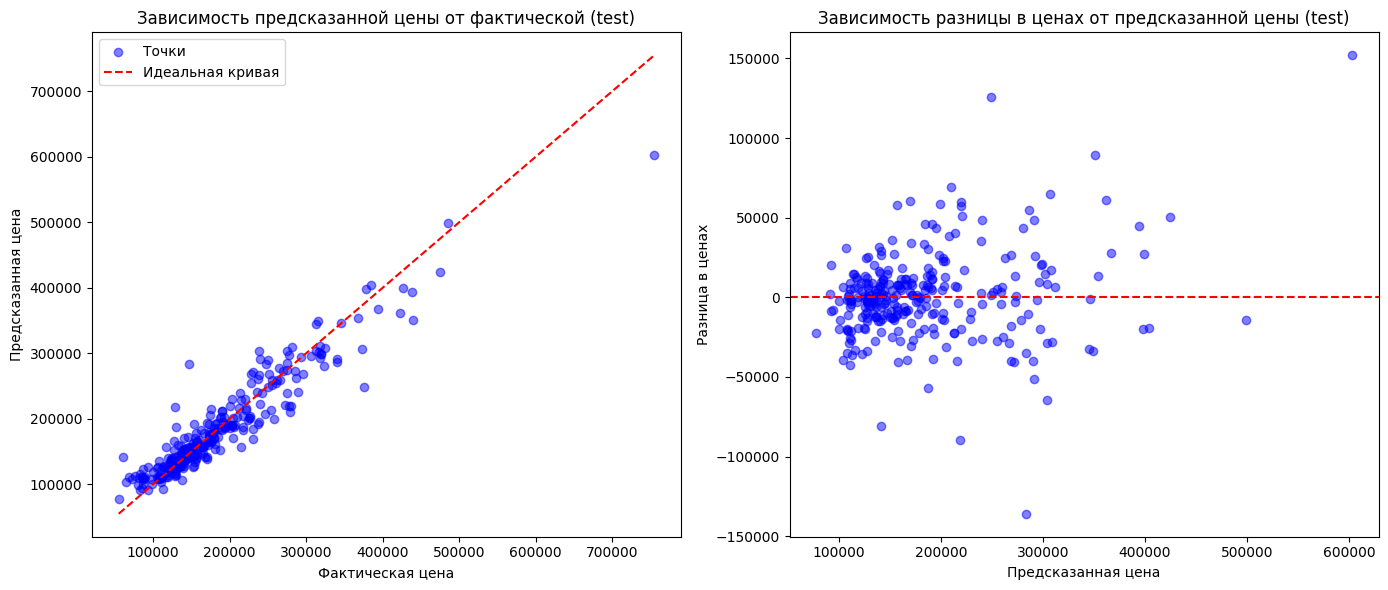

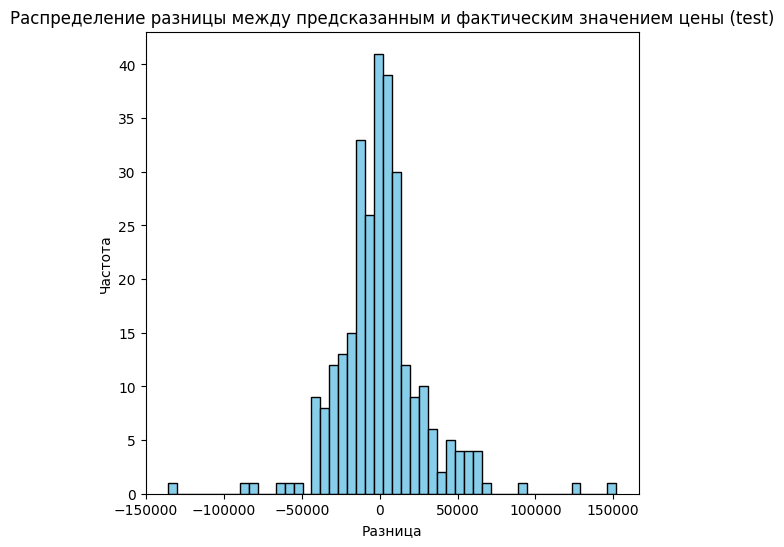

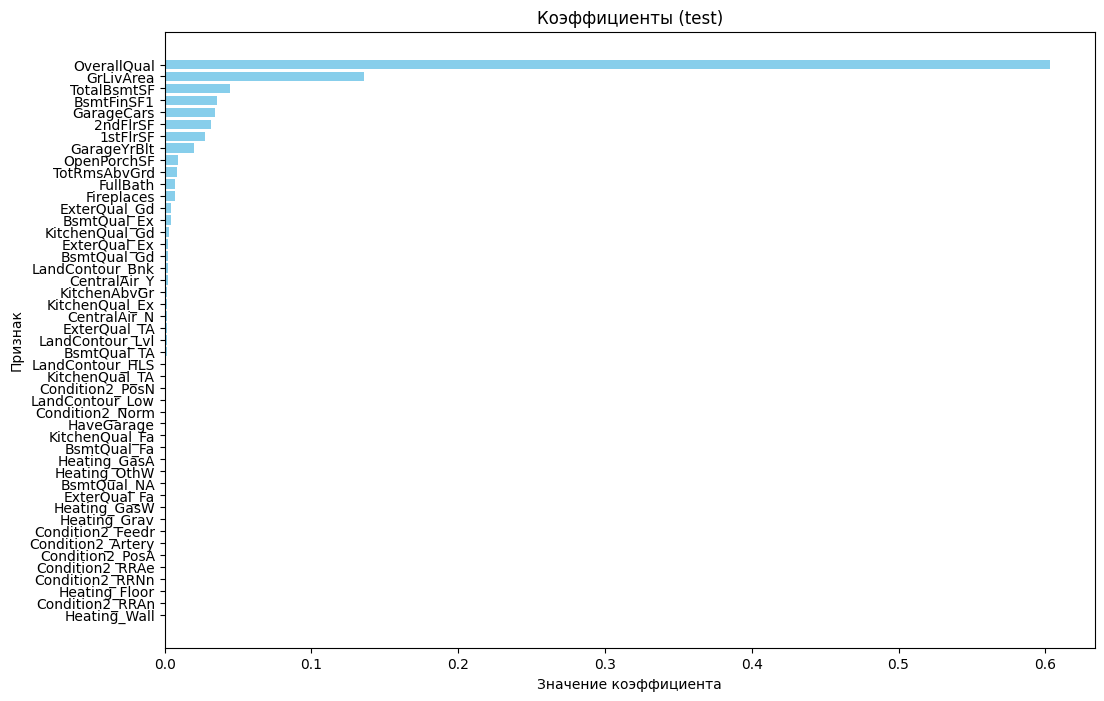


Имя модели: Случайный лес
Выборка : train
RMSE: 17884.0
MAPE: 8.09 %

Графики сравнения актуальных и предсказанных значений


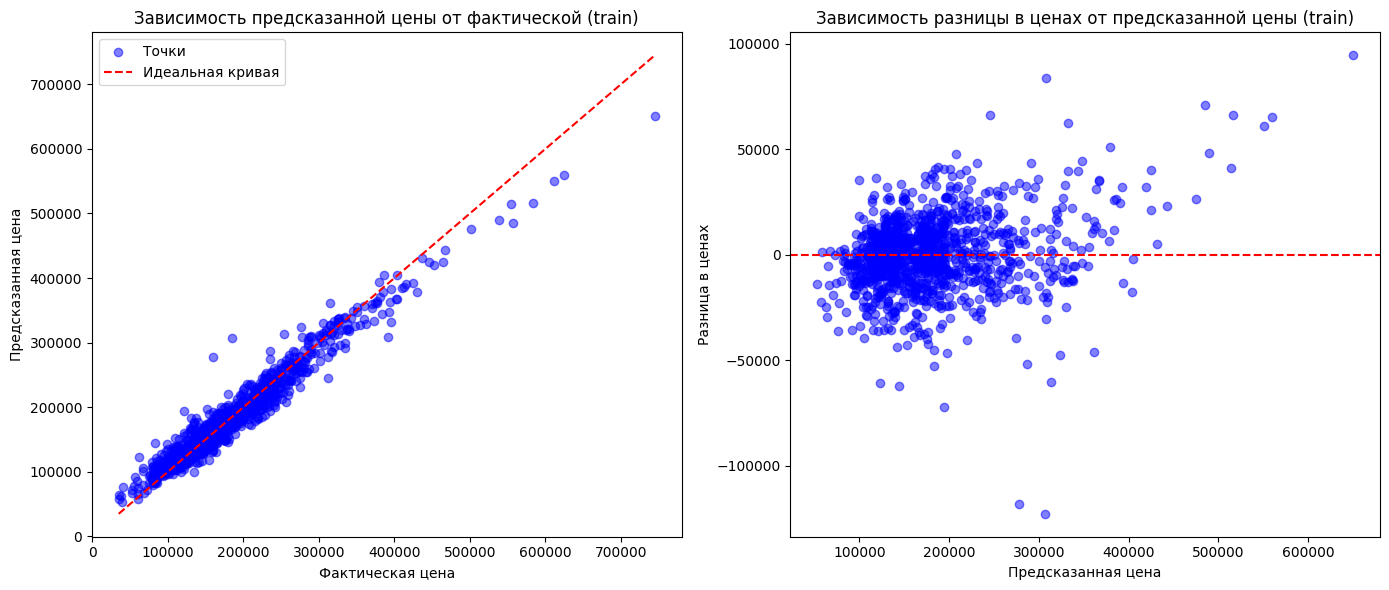

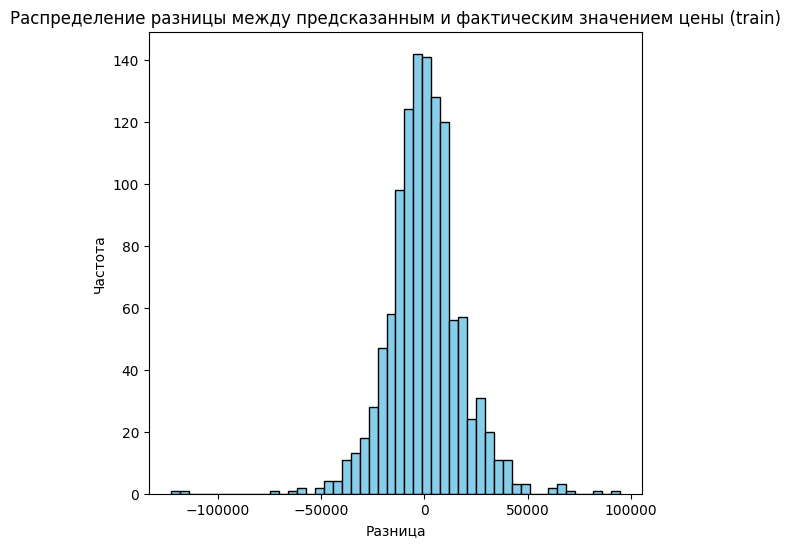

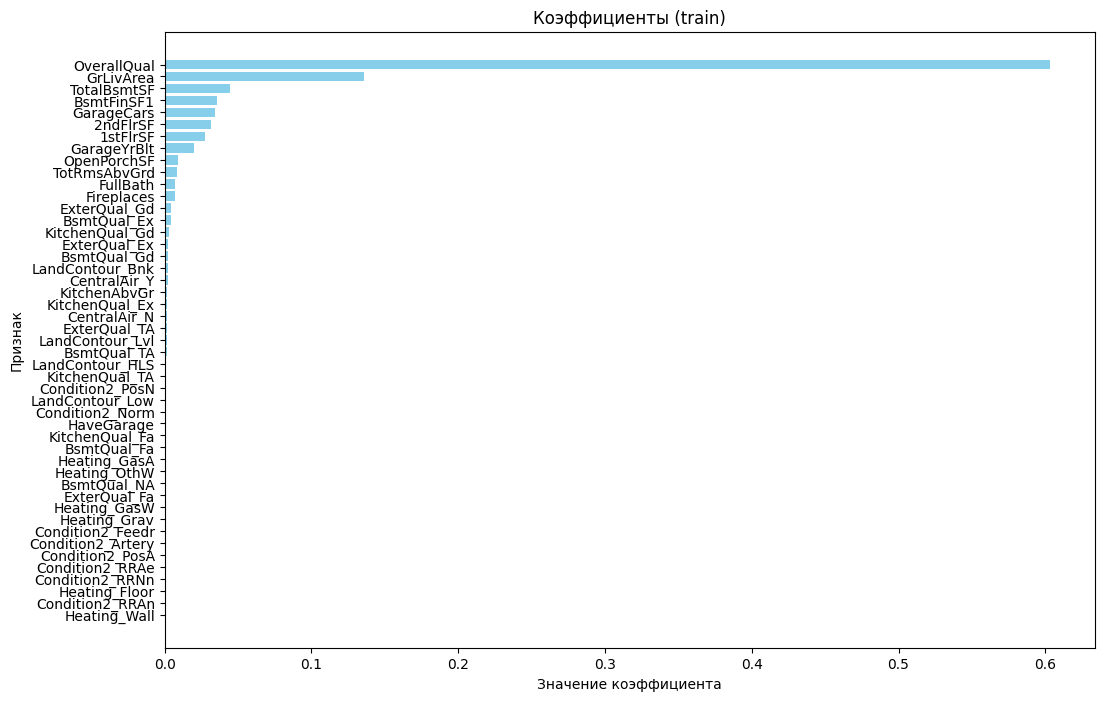

In [123]:
model_rf = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=7)
model_rf.fit(x_train, y_train)
show_result(model_rf, is_linear=False, is_rf=True, model_name='Случайный лес', show_train=True,
            show_test=True)

Модель избавилась от переобучения на тесте.

Поскольку мы разбили одну выборку на трейн и тест, то данные у нас похожие. А значит на новых данных при переобучении результат будет хуже. Уменьшив переобучение модель скорее всего будет лучше и стабильнее описывать неизвестные ей данные.

### Градиентный бустинг

Построим модель градиентного бустинга


Имя модели: Градиентный бустинг
Выборка : test
RMSE: 25985.0
MAPE: 10.42 %

Графики сравнения актуальных и предсказанных значений


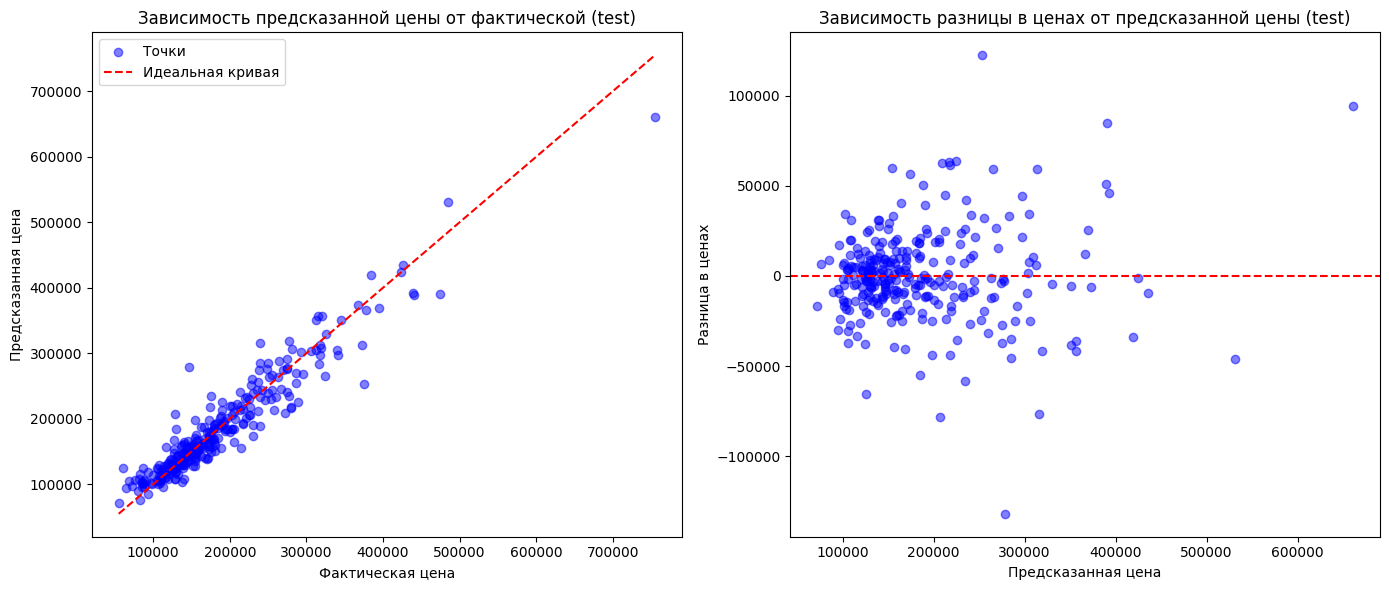

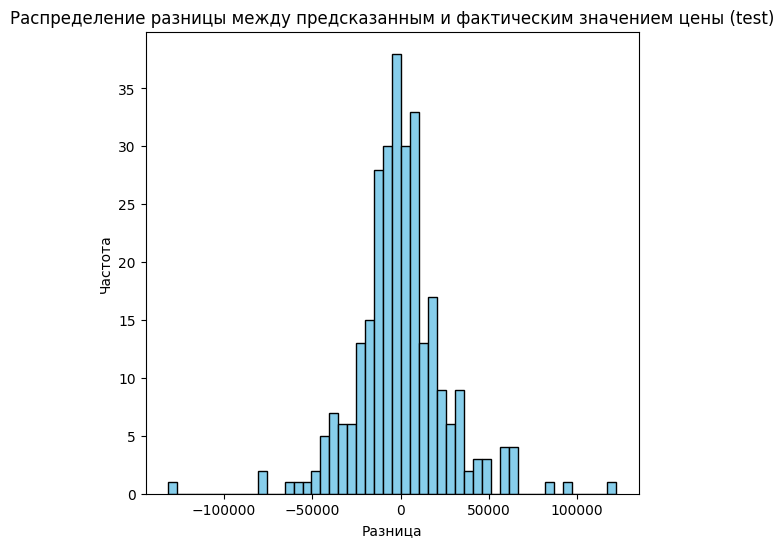

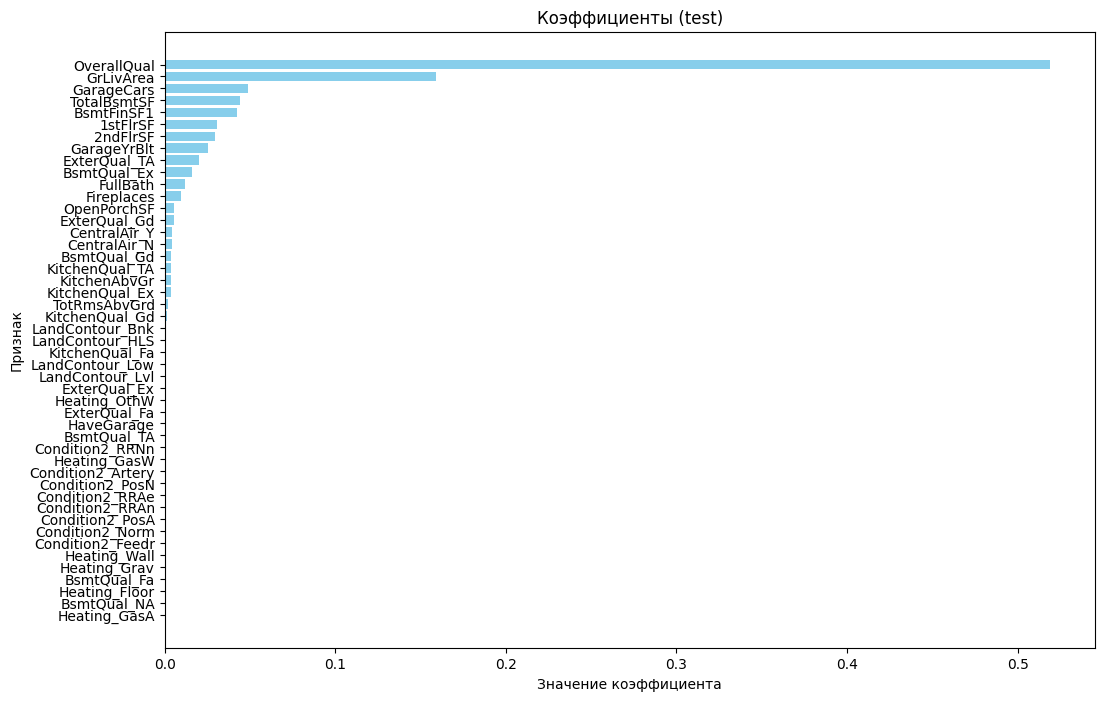


Имя модели: Градиентный бустинг
Выборка : train
RMSE: 16885.0
MAPE: 7.96 %

Графики сравнения актуальных и предсказанных значений


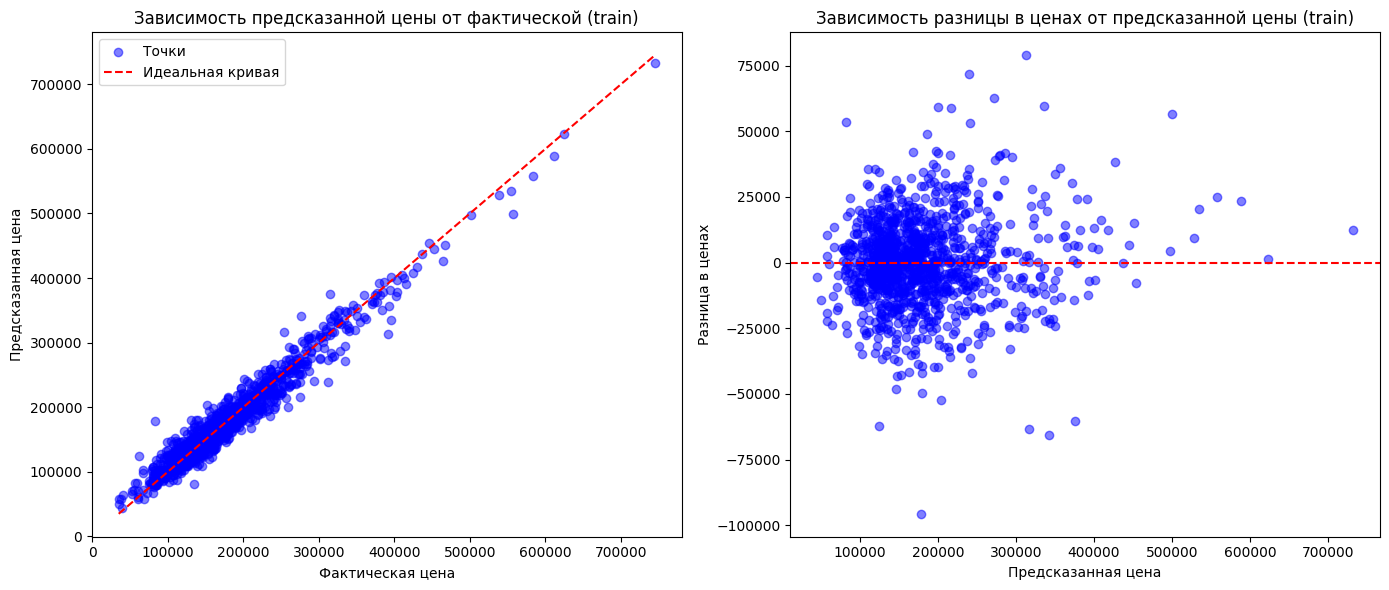

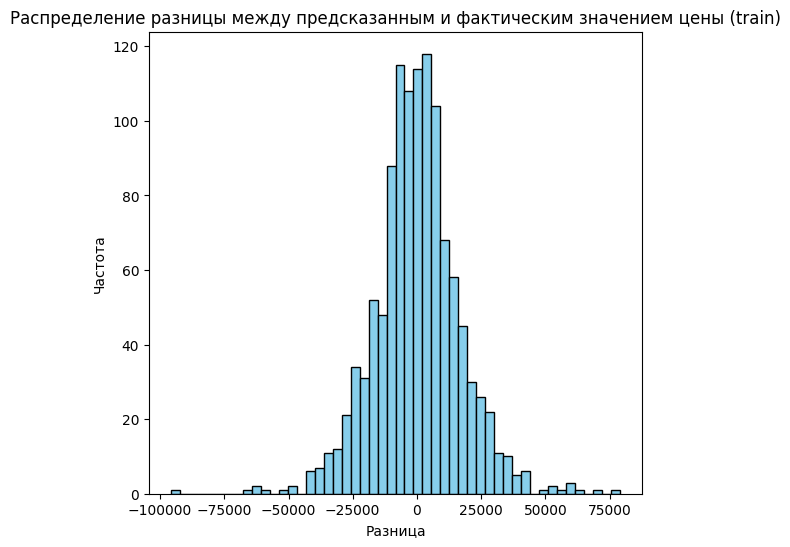

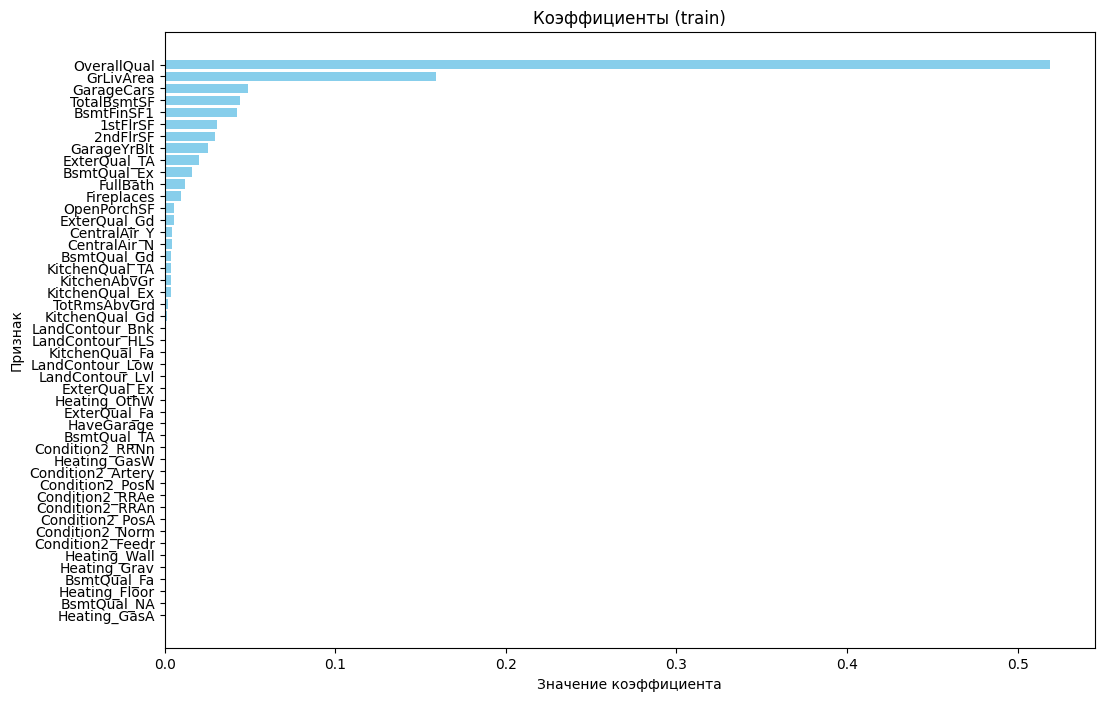

In [124]:
model_gb = GradientBoostingRegressor()
model_gb.fit(x_train, y_train)
show_result(model_gb, is_linear=False, is_rf=True, model_name='Градиентный бустинг', show_train=True,
            show_test=True)

Результаты очень похожи на случайный лес, но чуть лучше.

Попробуем подобрать параметры


Имя модели: Градиентный бустинг
Выборка : test
RMSE: 26027.0
MAPE: 10.46 %

Графики сравнения актуальных и предсказанных значений


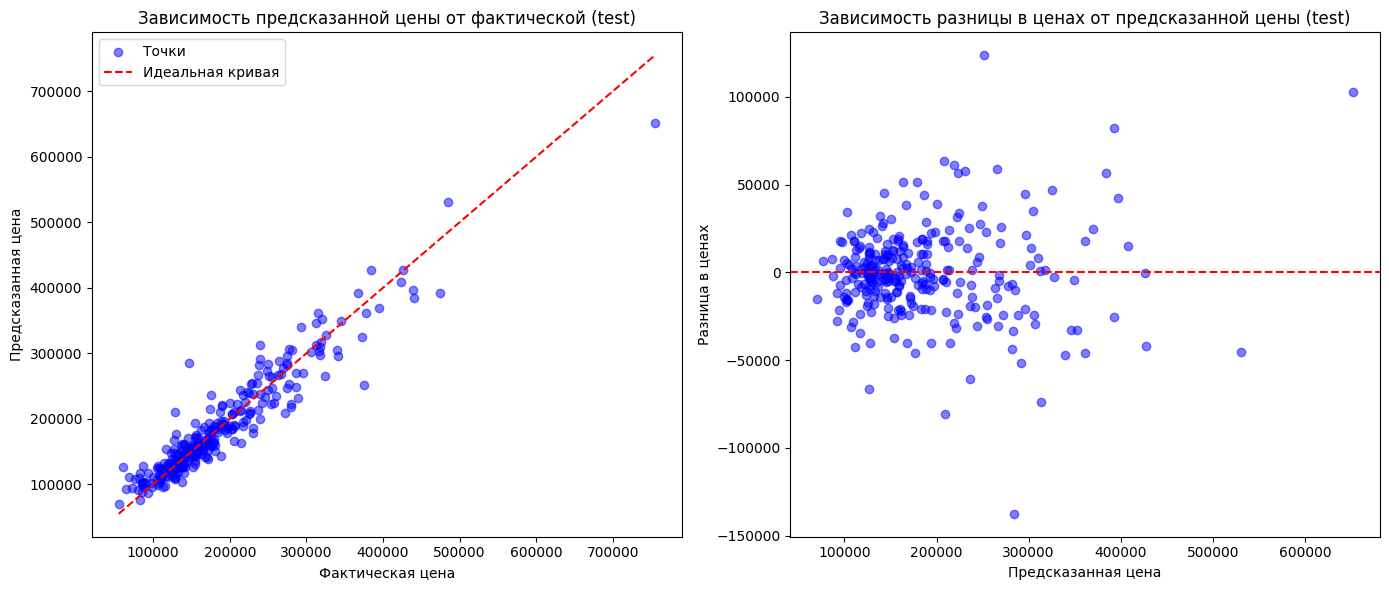

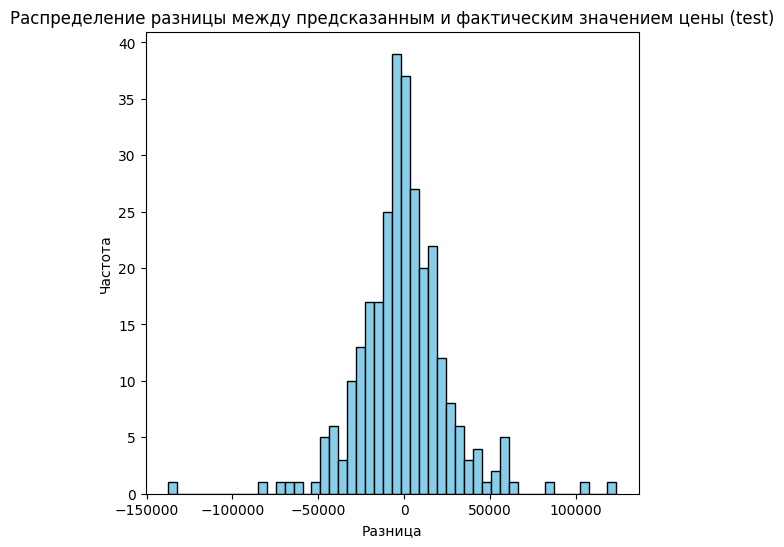

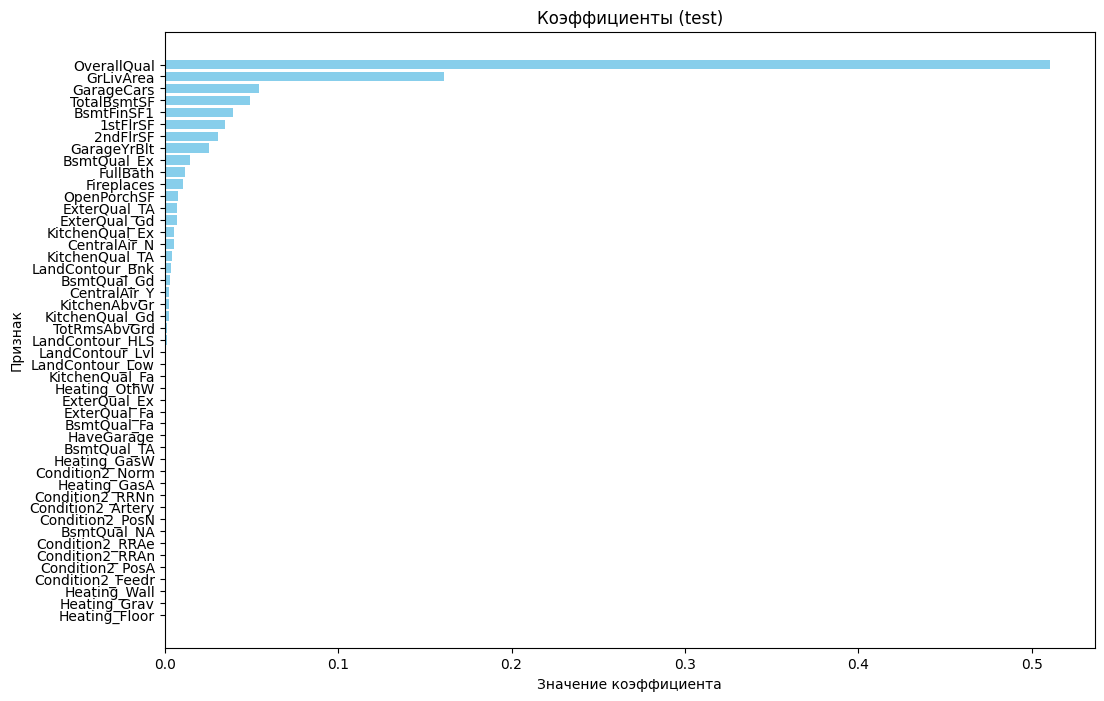


Имя модели: Градиентный бустинг
Выборка : train
RMSE: 13908.0
MAPE: 6.77 %

Графики сравнения актуальных и предсказанных значений


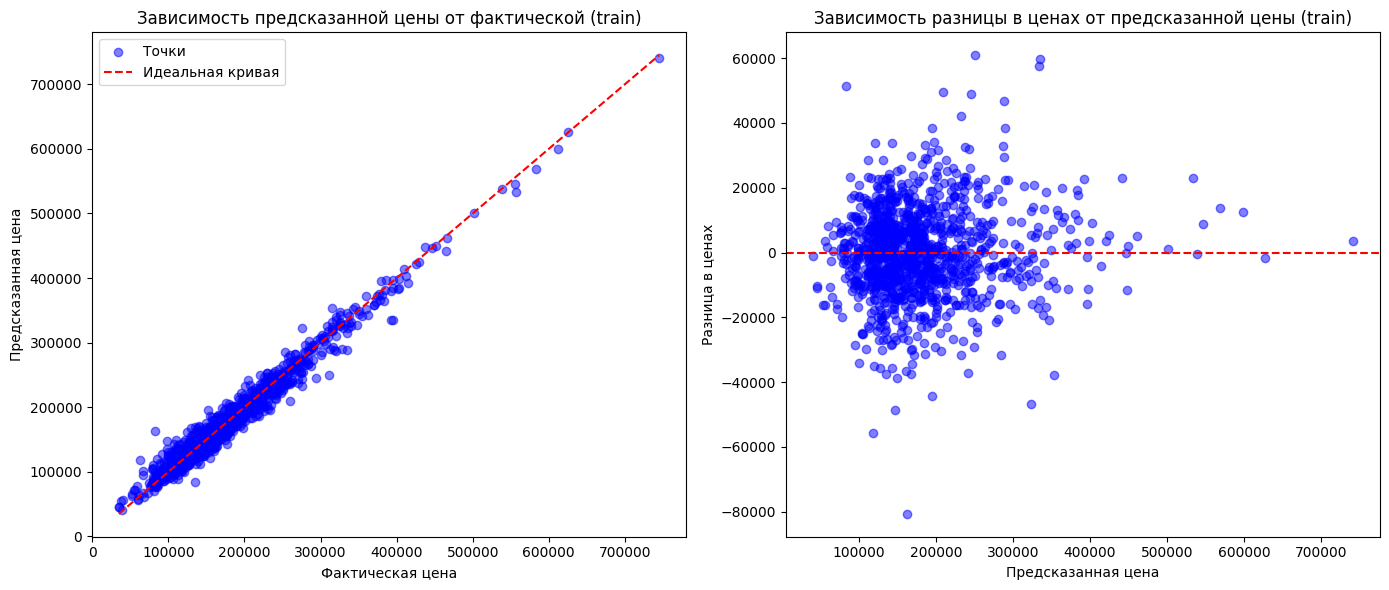

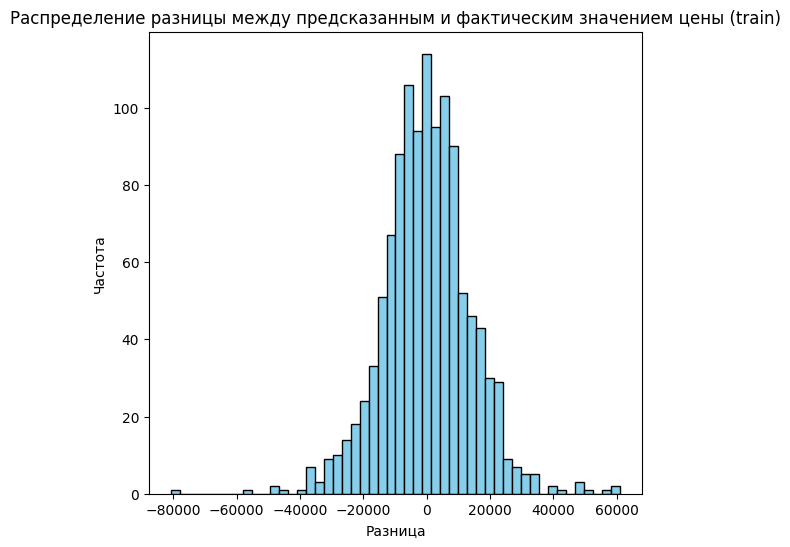

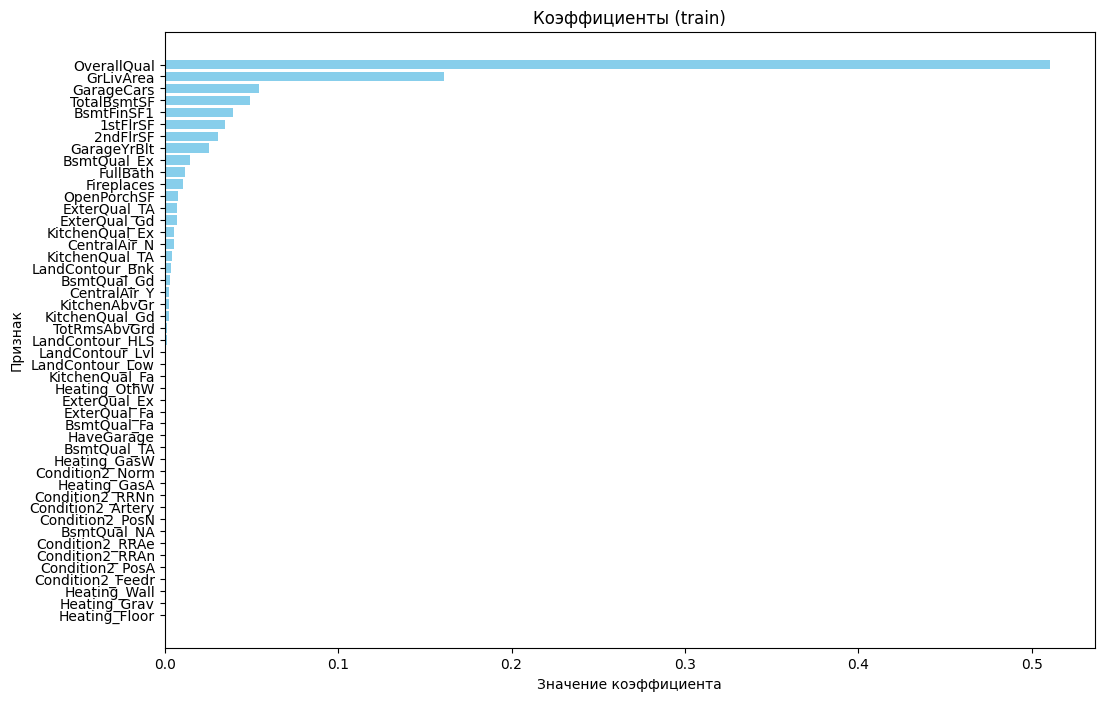

In [125]:
model_gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.04, max_depth=3, random_state=7)
model_gb.fit(x_train, y_train)
show_result(model_gb, is_linear=False, is_rf=True, model_name='Градиентный бустинг', show_train=True,
            show_test=True)

Модель градиентного бустинга показала наилучшие результаты предсказания.

Она, как и все остальные, хорошо описывает стоимость жилья в среднем ценовом сегменте. Но в отличии от линейной регрессии она также неплохо описывает стоимость дорогого и дешевого жилья.

Распределение разницы между предсказанным и фактическим значением цены близко к нормальному, что хорошо.

Критичный ошибок в предсказаниях не много, они скорее всего связаны с нестандартным жильем. Коэффициенты на многие признаки низкие, а в тех случаях скорее всего они играют решающую роль, хотя нельзя исключать и банальную ошибку в данных и тот самый дом просто был продан по сильно завышенной или заниженной цене.

## Предсказания

Мы уже подготовили датасет для предсказаний и обучили модель

Теперь необходимо сделать предсказание и оформить результат в соответствии с техническим заданием.

In [126]:
y_test_pred = model_gb.predict(df_test_encoded)
for i in range(len(y_test_pred)):
    y_test_pred[i] = round(y_test_pred[i], 6)
submission = df_sample.copy()
submission['SalePrice'] = y_test_pred

Посмотрим на получившийся результат

In [127]:
data_info(submission, 'submission')


submission

Размерность
(1459, 2)

Первые 10 строк
     Id      SalePrice
0  1461  138889.866119
1  1462  163310.479979
2  1463  214530.104978
3  1464  207682.269260
4  1465  267736.026444
5  1466  193422.810750
6  1467  183008.118065
7  1468  182796.080474
8  1469  227289.202329
9  1470  178288.877264

Последние 10 строк
        Id      SalePrice
1449  2910   82492.229932
1450  2911  121876.287640
1451  2912  174129.088029
1452  2913  119710.090445
1453  2914   74006.189921
1454  2915   74006.189921
1455  2916  119380.695032
1456  2917  177608.647366
1457  2918  120054.959453
1458  2919  284402.549709

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
None

Числовые статистики
                Id      Sale

Результат похож на правдоподобный. Числовые статистики SalePrice в нашем предсказании близки к числовым статистикам из нашей тренировочной выборки.

Теперь выгрузим наш датасет в формате csv

In [128]:
submission.to_csv('submission.csv')

## Спасибо за внимание

Если есть вопросы и пожелания - обращайтесь в [телеграмм](https://t.me/S_rozhd).

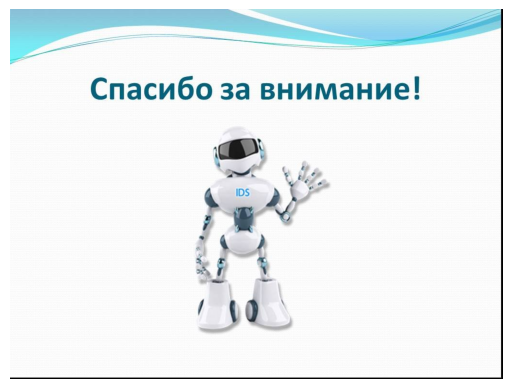

In [129]:
import cv2

# Чтение изображения
img = cv2.imread('robot.jpg')

# Преобразование цветового пространства с BGR (по умолчанию в OpenCV) в RGB (используется в matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Отображение изображения с помощью matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Отключить оси
plt.show()